<a href="https://colab.research.google.com/github/Kulikov17/MLDS_DL/blob/main/HW5/audio_digital_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем датасет из kaggle

In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle competitions download -c mlds-asr-competition-on-toloka-labelling

 92% 297M/323M [00:02<00:00, 99.5MB/s]
100% 323M/323M [00:02<00:00, 119MB/s] 


In [ ]:
# !unzip mlds-asr-competition-on-toloka-labelling.zip

In [1]:
import torch
import torch.nn.functional as F
import torchaudio
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pathlib
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython import display

RANDOM_SEED = 42

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Посмотрим запись из скаченного датасета

In [3]:
wav, sr = torchaudio.load('test/test/file0.mp3', format="mp3")

In [8]:
wav

tensor([[ 0.0001,  0.0002,  0.0002,  ..., -0.0002, -0.0002, -0.0001]])

In [9]:
wav.dtype

torch.float32

In [10]:
wav.shape

torch.Size([1, 34819])

In [36]:
sr

48000

In [4]:
def visualize_audio(wav: torch.Tensor, sr: int = 48000):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    display.display(display.Audio(wav, rate=sr))

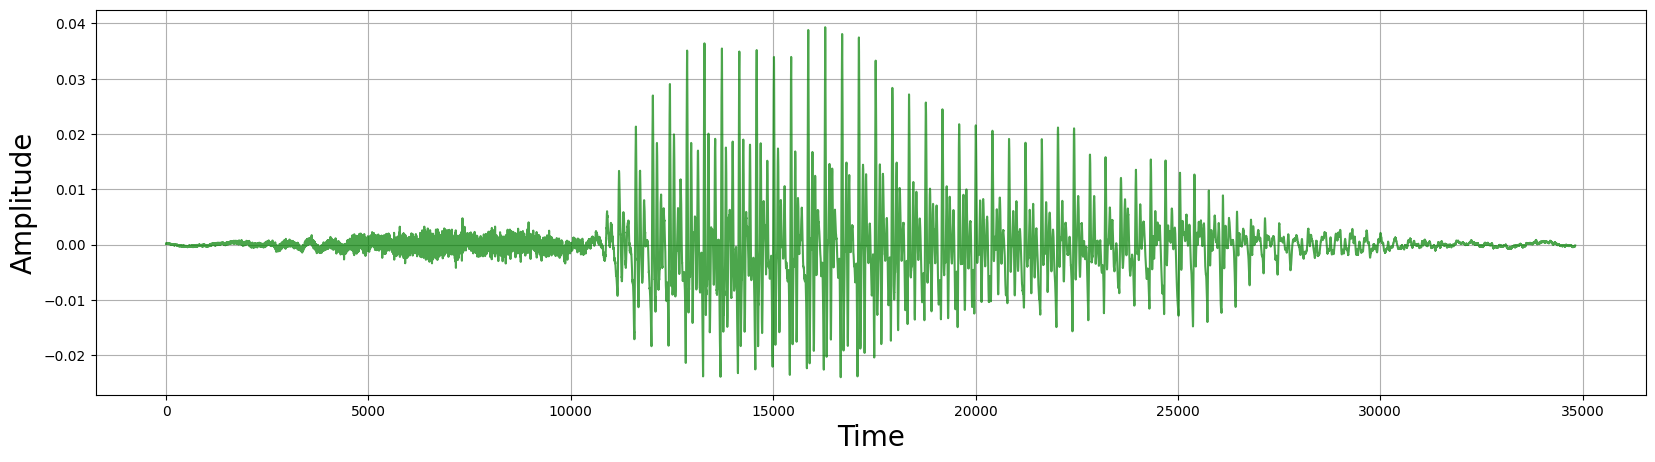

In [5]:
visualize_audio(wav)

In [6]:
class TolokaDataset(Dataset):
    def __init__(self, path_to_data: str):
        self.paths = []

        for i in range(10):
          filenames = pathlib.Path(f'{path_to_data}0{i}')
          files = list(filenames.rglob('*.mp3'))
          self.paths.extend(files)

    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()

        # Load mp3
        wav, sr = torchaudio.load(path_to_wav, format="mp3")

        label = int(path_to_wav.split('/')[-2])

        return wav, sr, label

    def __len__(self):
        return len(self.paths)

In [7]:
path_to_dataset = './datasetNumbers/datasetNumbers/'

In [8]:
dataset = TolokaDataset(path_to_dataset)

In [9]:
waveform, sample_rate, label = dataset[0]

Shape of waveform: torch.Size([1, 78480])
Sample rate of waveform: 48000


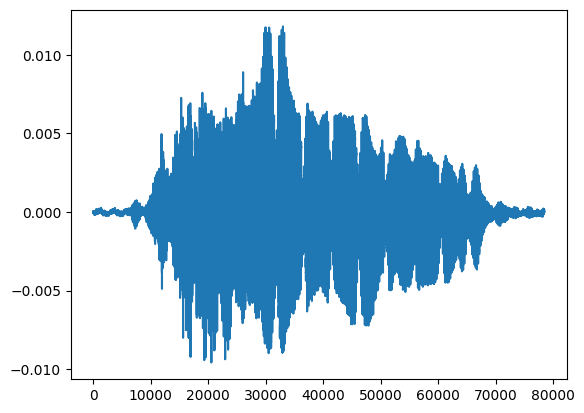

In [10]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [11]:
labels = sorted(list(set(datapoint[2] for datapoint in dataset)))
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Что касается формы сигнала, мы субдискретизируем звук для более быстрой обработки, не теряя при этом слишком большой мощности классификации.

Нам не нужно применять здесь другие преобразования. Однако для некоторых наборов данных обычно приходится уменьшать количество каналов (скажем, со стерео на моно), либо беря среднее значение по измерению канала, либо просто сохраняя только один из каналов. Поскольку данный датасет использует один канал для звука, здесь это не требуется.

In [12]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

display.Audio(transformed.numpy(), rate=new_sample_rate)

Мы кодируем каждое слово, используя его индекс в списке меток.

In [13]:
def label_to_index(digit):
    # Return the position of the word in labels
    return torch.tensor(labels.index(digit))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


digit_start = 3
index = label_to_index(digit_start)
digit_recovered = index_to_label(index)

print(digit_start, "-->", index, "-->", digit_recovered)

3 --> tensor(3) --> 3


In [14]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)

In [15]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

При выполнении ДЗ, хочу сравнить две модели M5, M11, M18.

Подробнее см. источники:

1. https://arxiv.org/pdf/1610.00087.pdf
2. https://jovian.com/gtaljaard/assignment-4-speech-command-recognition-with-m3-m5-m11-m18-cnn-networks
3. https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

In [33]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model_m5 = M5(n_input=transformed.shape[0], n_output=len(labels))
model_m5.to(device)

print(model_m5)
print("Number of parameters: %s" % count_parameters(model_m5))

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Number

In [81]:
class M11(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, n_channel=64):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)

        self.conv6 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(4 * n_channel)
        self.conv7 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(4 * n_channel)
        self.conv8 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4)

        self.conv9 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(8 * n_channel)
        self.conv10 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(8 * n_channel)

        self.fc1 = nn.Linear(8 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool2(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool3(x)

        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = self.pool4(x)

        x = self.conv9(x)
        x = F.relu(self.bn9(x))
        x = self.conv10(x)
        x = F.relu(self.bn10(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model_m11 = M11(n_input=transformed.shape[0], n_output=len(labels))
model_m11.to(device)

print(model_m11)
print("Number of parameters: %s" % count_parameters(model_m11))

M11(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size

In [70]:
class M18(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, n_channel=64):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4, stride=None)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.conv4 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(n_channel)
        self.conv5 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4, stride=None)

        self.conv6 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(2 * n_channel)
        self.conv7 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(2 * n_channel)
        self.conv8 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(2 * n_channel)
        self.conv9 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4, stride=None)

        self.conv10 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(4 * n_channel)
        self.conv11 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm1d(4 * n_channel)
        self.conv12 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm1d(4 * n_channel)
        self.conv13 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn13 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4, stride=None)

        self.conv14 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn14 = nn.BatchNorm1d(8 * n_channel)
        self.conv15 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn15 = nn.BatchNorm1d(8 * n_channel)
        self.conv16 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn16 = nn.BatchNorm1d(8 * n_channel)
        self.conv17 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn17 = nn.BatchNorm1d(8 * n_channel)

        self.fc1 = nn.Linear(8 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool2(x)

        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = self.conv9(x)
        x = F.relu(self.bn9(x))
        x = self.pool3(x)

        x = self.conv10(x)
        x = F.relu(self.bn10(x))
        x = self.conv11(x)
        x = F.relu(self.bn11(x))
        x = self.conv12(x)
        x = F.relu(self.bn12(x))
        x = self.conv13(x)
        x = F.relu(self.bn13(x))
        x = self.pool4(x)

        x = self.conv14(x)
        x = F.relu(self.bn14(x))
        x = self.conv15(x)
        x = F.relu(self.bn15(x))
        x = self.conv16(x)
        x = F.relu(self.bn16(x))
        x = self.conv17(x)
        x = F.relu(self.bn17(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model_m18 = M18(n_input=transformed.shape[0], n_output=len(labels))
model_m18.to(device)

print(model_m18)
print("Number of parameters: %s" % count_parameters(model_m18))

M18(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv1d(64, 128, kernel_siz

In [18]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

In [19]:
def train(model, optimizer, epoch, log_interval):
    model.train()
    right = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        right += number_of_correct(pred, target)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(train_loader.dataset)} ({100. * right / len(train_loader.dataset):.0f}%)")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [20]:
def test(model, epoch):
    model.eval()
    right = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        right += number_of_correct(pred, target)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch} \tLoss: {loss.item():.6f}\tAccuracy: {right}/{len(test_loader.dataset)} ({100. * right / len(test_loader.dataset):.0f}%)\n")

    acc = 100. * right / len(test_loader.dataset)
    accuracy_test.append(acc)
    losses_test.append(loss.item())

In [21]:
log_interval = 20
n_epoch = 30
pbar_update = 1 / (len(train_loader) + len(test_loader))

Обучим M5

In [34]:
optimizer = optim.Adam(model_m5.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

losses = []
accuracy_test = []
losses_test = []
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_m5, optimizer, epoch, log_interval)
        test(model_m5, epoch)
        scheduler.step()


  0%|          | 0.013422818791946308/30 [00:00<09:46, 19.55s/it]

Train Epoch: 1 [0/30441 (0%)]	Loss: 2.292714	Accuracy: 40/30441 (0%)


  0%|          | 0.14765100671140938/30 [00:02<09:22, 18.84s/it]

Train Epoch: 1 [5120/30441 (17%)]	Loss: 1.421813	Accuracy: 2071/30441 (7%)


  1%|          | 0.2818791946308723/30 [00:05<09:09, 18.49s/it] 

Train Epoch: 1 [10240/30441 (34%)]	Loss: 0.896399	Accuracy: 5279/30441 (17%)


  1%|▏         | 0.40939597315436205/30 [00:07<10:10, 20.64s/it]

Train Epoch: 1 [15360/30441 (50%)]	Loss: 0.860609	Accuracy: 9032/30441 (30%)


  2%|▏         | 0.5503355704697981/30 [00:10<10:41, 21.78s/it]

Train Epoch: 1 [20480/30441 (67%)]	Loss: 0.891883	Accuracy: 12977/30441 (43%)


  2%|▏         | 0.684563758389261/30 [00:13<09:12, 18.85s/it] 

Train Epoch: 1 [25600/30441 (84%)]	Loss: 0.589029	Accuracy: 17125/30441 (56%)


  3%|▎         | 1.006711409395972/30 [00:18<06:52, 14.23s/it] 


Test Epoch: 1 	Loss: 13.464746	Accuracy: 735/7611 (10%)

Train Epoch: 2 [0/30441 (0%)]	Loss: 0.420074	Accuracy: 228/30441 (1%)


  4%|▍         | 1.1476510067114103/30 [00:21<08:41, 18.07s/it]

Train Epoch: 2 [5120/30441 (17%)]	Loss: 0.478629	Accuracy: 4674/30441 (15%)


  4%|▍         | 1.2818791946308754/30 [00:23<10:17, 21.50s/it]

Train Epoch: 2 [10240/30441 (34%)]	Loss: 0.485861	Accuracy: 9139/30441 (30%)


  5%|▍         | 1.4161073825503405/30 [00:26<08:54, 18.72s/it]

Train Epoch: 2 [15360/30441 (50%)]	Loss: 0.613148	Accuracy: 13635/30441 (45%)


  5%|▌         | 1.5436241610738324/30 [00:28<09:30, 20.04s/it]

Train Epoch: 2 [20480/30441 (67%)]	Loss: 0.559765	Accuracy: 18202/30441 (60%)


  6%|▌         | 1.6845637583892707/30 [00:31<08:42, 18.45s/it]

Train Epoch: 2 [25600/30441 (84%)]	Loss: 0.487831	Accuracy: 22823/30441 (75%)


  7%|▋         | 2.006711409395987/30 [00:36<08:12, 17.59s/it] 


Test Epoch: 2 	Loss: 28.055309	Accuracy: 737/7611 (10%)

Train Epoch: 3 [0/30441 (0%)]	Loss: 0.371464	Accuracy: 242/30441 (1%)


  7%|▋         | 2.1476510067114254/30 [00:39<08:37, 18.57s/it]

Train Epoch: 3 [5120/30441 (17%)]	Loss: 0.379620	Accuracy: 4943/30441 (16%)


  8%|▊         | 2.2818791946308905/30 [00:42<08:40, 18.79s/it]

Train Epoch: 3 [10240/30441 (34%)]	Loss: 0.496785	Accuracy: 9661/30441 (32%)


  8%|▊         | 2.4161073825503556/30 [00:44<08:34, 18.64s/it]

Train Epoch: 3 [15360/30441 (50%)]	Loss: 0.424766	Accuracy: 14411/30441 (47%)


  9%|▊         | 2.5503355704698207/30 [00:47<09:10, 20.05s/it]

Train Epoch: 3 [20480/30441 (67%)]	Loss: 0.361151	Accuracy: 19125/30441 (63%)


  9%|▉         | 2.684563758389286/30 [00:49<08:54, 19.55s/it] 

Train Epoch: 3 [25600/30441 (84%)]	Loss: 0.295952	Accuracy: 23914/30441 (79%)


 10%|█         | 3.006711409396002/30 [00:54<06:19, 14.04s/it] 


Test Epoch: 3 	Loss: 23.457779	Accuracy: 767/7611 (10%)

Train Epoch: 4 [0/30441 (0%)]	Loss: 0.458448	Accuracy: 237/30441 (1%)


 10%|█         | 3.1476510067114405/30 [00:57<08:30, 19.02s/it]

Train Epoch: 4 [5120/30441 (17%)]	Loss: 0.238789	Accuracy: 5067/30441 (17%)


 11%|█         | 3.2818791946309056/30 [01:00<09:16, 20.83s/it]

Train Epoch: 4 [10240/30441 (34%)]	Loss: 0.334287	Accuracy: 9891/30441 (32%)


 11%|█▏        | 3.4161073825503707/30 [01:02<08:25, 19.03s/it]

Train Epoch: 4 [15360/30441 (50%)]	Loss: 0.350163	Accuracy: 14707/30441 (48%)


 12%|█▏        | 3.5436241610738626/30 [01:05<08:36, 19.54s/it]

Train Epoch: 4 [20480/30441 (67%)]	Loss: 0.306970	Accuracy: 19559/30441 (64%)


 12%|█▏        | 3.684563758389301/30 [01:07<07:57, 18.16s/it] 

Train Epoch: 4 [25600/30441 (84%)]	Loss: 0.361198	Accuracy: 24409/30441 (80%)


 13%|█▎        | 4.006711409396017/30 [01:13<07:19, 16.91s/it] 


Test Epoch: 4 	Loss: 22.150488	Accuracy: 793/7611 (10%)

Train Epoch: 5 [0/30441 (0%)]	Loss: 0.247339	Accuracy: 245/30441 (1%)


 14%|█▍        | 4.147651006711455/30 [01:15<08:04, 18.74s/it]

Train Epoch: 5 [5120/30441 (17%)]	Loss: 0.353526	Accuracy: 5099/30441 (17%)


 14%|█▍        | 4.28187919463092/30 [01:18<07:59, 18.65s/it] 

Train Epoch: 5 [10240/30441 (34%)]	Loss: 0.362934	Accuracy: 9959/30441 (33%)


 15%|█▍        | 4.416107382550385/30 [01:20<08:06, 19.03s/it]

Train Epoch: 5 [15360/30441 (50%)]	Loss: 0.235273	Accuracy: 14805/30441 (49%)


 15%|█▌        | 4.5503355704698505/30 [01:23<07:50, 18.50s/it]

Train Epoch: 5 [20480/30441 (67%)]	Loss: 0.334295	Accuracy: 19669/30441 (65%)


 16%|█▌        | 4.684563758389316/30 [01:26<09:10, 21.74s/it]

Train Epoch: 5 [25600/30441 (84%)]	Loss: 0.362461	Accuracy: 24545/30441 (81%)


 17%|█▋        | 5.006711409396032/30 [01:31<05:47, 13.89s/it]


Test Epoch: 5 	Loss: 9.771942	Accuracy: 1236/7611 (16%)

Train Epoch: 6 [0/30441 (0%)]	Loss: 0.323061	Accuracy: 244/30441 (1%)


 17%|█▋        | 5.140939597315497/30 [01:33<08:09, 19.69s/it]

Train Epoch: 6 [5120/30441 (17%)]	Loss: 0.384276	Accuracy: 5096/30441 (17%)


 18%|█▊        | 5.281879194630935/30 [01:36<07:42, 18.72s/it]

Train Epoch: 6 [10240/30441 (34%)]	Loss: 0.253138	Accuracy: 9958/30441 (33%)


 18%|█▊        | 5.4161073825504005/30 [01:39<07:41, 18.79s/it]

Train Epoch: 6 [15360/30441 (50%)]	Loss: 0.249406	Accuracy: 14857/30441 (49%)


 18%|█▊        | 5.543624161073892/30 [01:41<08:05, 19.86s/it]

Train Epoch: 6 [20480/30441 (67%)]	Loss: 0.338522	Accuracy: 19714/30441 (65%)


 19%|█▉        | 5.6778523489933574/30 [01:44<08:05, 19.95s/it]

Train Epoch: 6 [25600/30441 (84%)]	Loss: 0.274500	Accuracy: 24596/30441 (81%)


 20%|██        | 6.006711409396047/30 [01:49<06:25, 16.07s/it] 


Test Epoch: 6 	Loss: 9.435565	Accuracy: 867/7611 (11%)

Train Epoch: 7 [0/30441 (0%)]	Loss: 0.268356	Accuracy: 245/30441 (1%)


 20%|██        | 6.140939597315512/30 [01:52<07:53, 19.86s/it]

Train Epoch: 7 [5120/30441 (17%)]	Loss: 0.326126	Accuracy: 5158/30441 (17%)


 21%|██        | 6.2818791946309505/30 [01:54<07:28, 18.91s/it]

Train Epoch: 7 [10240/30441 (34%)]	Loss: 0.166096	Accuracy: 10067/30441 (33%)


 21%|██▏       | 6.409395973154442/30 [01:57<07:48, 19.85s/it]

Train Epoch: 7 [15360/30441 (50%)]	Loss: 0.308878	Accuracy: 14988/30441 (49%)


 22%|██▏       | 6.543624161073907/30 [01:59<07:56, 20.31s/it]

Train Epoch: 7 [20480/30441 (67%)]	Loss: 0.346039	Accuracy: 19874/30441 (65%)


 22%|██▏       | 6.684563758389346/30 [02:02<08:05, 20.84s/it] 

Train Epoch: 7 [25600/30441 (84%)]	Loss: 0.235559	Accuracy: 24764/30441 (81%)


 23%|██▎       | 7.006711409396062/30 [02:07<05:19, 13.89s/it]


Test Epoch: 7 	Loss: 6.691399	Accuracy: 921/7611 (12%)

Train Epoch: 8 [0/30441 (0%)]	Loss: 0.283086	Accuracy: 243/30441 (1%)


 24%|██▍       | 7.140939597315527/30 [02:10<07:36, 19.98s/it]

Train Epoch: 8 [5120/30441 (17%)]	Loss: 0.261327	Accuracy: 5139/30441 (17%)


 24%|██▍       | 7.281879194630966/30 [02:12<06:55, 18.30s/it]

Train Epoch: 8 [10240/30441 (34%)]	Loss: 0.230960	Accuracy: 10050/30441 (33%)


 25%|██▍       | 7.416107382550431/30 [02:15<07:53, 20.97s/it]

Train Epoch: 8 [15360/30441 (50%)]	Loss: 0.445149	Accuracy: 14944/30441 (49%)


 25%|██▌       | 7.5436241610739225/30 [02:18<07:22, 19.71s/it]

Train Epoch: 8 [20480/30441 (67%)]	Loss: 0.171615	Accuracy: 19839/30441 (65%)


 26%|██▌       | 7.684563758389361/30 [02:20<06:51, 18.42s/it]

Train Epoch: 8 [25600/30441 (84%)]	Loss: 0.302908	Accuracy: 24733/30441 (81%)


 27%|██▋       | 8.006711409396075/30 [02:25<05:07, 13.98s/it]


Test Epoch: 8 	Loss: 4.826340	Accuracy: 1061/7611 (14%)

Train Epoch: 9 [0/30441 (0%)]	Loss: 0.316856	Accuracy: 246/30441 (1%)


 27%|██▋       | 8.140939597315523/30 [02:28<07:36, 20.88s/it]

Train Epoch: 9 [5120/30441 (17%)]	Loss: 0.322426	Accuracy: 5145/30441 (17%)


 28%|██▊       | 8.281879194630942/30 [02:31<06:53, 19.02s/it]

Train Epoch: 9 [10240/30441 (34%)]	Loss: 0.267632	Accuracy: 10065/30441 (33%)


 28%|██▊       | 8.409395973154417/30 [02:33<07:05, 19.70s/it]

Train Epoch: 9 [15360/30441 (50%)]	Loss: 0.232125	Accuracy: 14957/30441 (49%)


 29%|██▊       | 8.550335570469837/30 [02:36<06:50, 19.13s/it]

Train Epoch: 9 [20480/30441 (67%)]	Loss: 0.158491	Accuracy: 19883/30441 (65%)


 29%|██▉       | 8.684563758389285/30 [02:38<07:30, 21.11s/it]

Train Epoch: 9 [25600/30441 (84%)]	Loss: 0.231990	Accuracy: 24765/30441 (81%)


 30%|███       | 9.006711409395958/30 [02:43<04:57, 14.18s/it]


Test Epoch: 9 	Loss: 7.893501	Accuracy: 1128/7611 (15%)

Train Epoch: 10 [0/30441 (0%)]	Loss: 0.303547	Accuracy: 240/30441 (1%)


 30%|███       | 9.147651006711378/30 [02:46<06:18, 18.13s/it]

Train Epoch: 10 [5120/30441 (17%)]	Loss: 0.281211	Accuracy: 5172/30441 (17%)


 31%|███       | 9.275167785234853/30 [02:48<06:50, 19.82s/it]

Train Epoch: 10 [10240/30441 (34%)]	Loss: 0.290706	Accuracy: 10074/30441 (33%)


 31%|███▏      | 9.416107382550273/30 [02:51<07:21, 21.46s/it]

Train Epoch: 10 [15360/30441 (50%)]	Loss: 0.313517	Accuracy: 14961/30441 (49%)


 32%|███▏      | 9.55033557046972/30 [02:54<06:15, 18.38s/it] 

Train Epoch: 10 [20480/30441 (67%)]	Loss: 0.273953	Accuracy: 19867/30441 (65%)


 32%|███▏      | 9.684563758389167/30 [02:56<06:21, 18.77s/it]

Train Epoch: 10 [25600/30441 (84%)]	Loss: 0.401972	Accuracy: 24763/30441 (81%)


 33%|███▎      | 10.006711409395841/30 [03:02<04:42, 14.12s/it]


Test Epoch: 10 	Loss: 12.334542	Accuracy: 810/7611 (11%)

Train Epoch: 11 [0/30441 (0%)]	Loss: 0.259316	Accuracy: 246/30441 (1%)


 34%|███▍      | 10.14765100671126/30 [03:04<07:16, 22.01s/it] 

Train Epoch: 11 [5120/30441 (17%)]	Loss: 0.363134	Accuracy: 5144/30441 (17%)


 34%|███▍      | 10.281879194630708/30 [03:07<06:03, 18.46s/it]

Train Epoch: 11 [10240/30441 (34%)]	Loss: 0.251700	Accuracy: 10057/30441 (33%)


 35%|███▍      | 10.416107382550155/30 [03:10<06:29, 19.90s/it]

Train Epoch: 11 [15360/30441 (50%)]	Loss: 0.204902	Accuracy: 14979/30441 (49%)


 35%|███▌      | 10.550335570469603/30 [03:12<06:04, 18.75s/it]

Train Epoch: 11 [20480/30441 (67%)]	Loss: 0.247274	Accuracy: 19911/30441 (65%)


 36%|███▌      | 10.677852348993078/30 [03:15<06:29, 20.16s/it]

Train Epoch: 11 [25600/30441 (84%)]	Loss: 0.319940	Accuracy: 24815/30441 (82%)


 37%|███▋      | 11.006711409395724/30 [03:20<04:26, 14.03s/it]


Test Epoch: 11 	Loss: 20.181332	Accuracy: 772/7611 (10%)

Train Epoch: 12 [0/30441 (0%)]	Loss: 0.223455	Accuracy: 250/30441 (1%)


 37%|███▋      | 11.147651006711143/30 [03:23<05:47, 18.44s/it]

Train Epoch: 12 [5120/30441 (17%)]	Loss: 0.197697	Accuracy: 5163/30441 (17%)


 38%|███▊      | 11.28187919463059/30 [03:25<05:53, 18.91s/it] 

Train Epoch: 12 [10240/30441 (34%)]	Loss: 0.245128	Accuracy: 10055/30441 (33%)


 38%|███▊      | 11.416107382550038/30 [03:28<06:10, 19.91s/it]

Train Epoch: 12 [15360/30441 (50%)]	Loss: 0.284033	Accuracy: 14972/30441 (49%)


 39%|███▊      | 11.550335570469485/30 [03:30<05:45, 18.72s/it]

Train Epoch: 12 [20480/30441 (67%)]	Loss: 0.221116	Accuracy: 19873/30441 (65%)


 39%|███▉      | 11.684563758388933/30 [03:33<05:42, 18.72s/it]

Train Epoch: 12 [25600/30441 (84%)]	Loss: 0.308327	Accuracy: 24777/30441 (81%)


 40%|████      | 12.006711409395606/30 [03:38<04:13, 14.07s/it]


Test Epoch: 12 	Loss: 11.126921	Accuracy: 869/7611 (11%)

Train Epoch: 13 [0/30441 (0%)]	Loss: 0.221148	Accuracy: 246/30441 (1%)


 40%|████      | 12.147651006711026/30 [03:41<06:09, 20.69s/it]

Train Epoch: 13 [5120/30441 (17%)]	Loss: 0.206177	Accuracy: 5181/30441 (17%)


 41%|████      | 12.281879194630474/30 [03:43<05:32, 18.77s/it]

Train Epoch: 13 [10240/30441 (34%)]	Loss: 0.224985	Accuracy: 10089/30441 (33%)


 41%|████▏     | 12.41610738254992/30 [03:46<05:35, 19.10s/it] 

Train Epoch: 13 [15360/30441 (50%)]	Loss: 0.187912	Accuracy: 14977/30441 (49%)


 42%|████▏     | 12.543624161073396/30 [03:48<05:50, 20.06s/it]

Train Epoch: 13 [20480/30441 (67%)]	Loss: 0.253951	Accuracy: 19886/30441 (65%)


 42%|████▏     | 12.684563758388816/30 [03:51<05:25, 18.78s/it]

Train Epoch: 13 [25600/30441 (84%)]	Loss: 0.245429	Accuracy: 24813/30441 (82%)


 43%|████▎     | 12.999999999999517/30 [03:56<03:45, 13.29s/it]


Test Epoch: 13 	Loss: 5.802012	Accuracy: 1924/7611 (25%)

Train Epoch: 14 [0/30441 (0%)]	Loss: 0.241182	Accuracy: 244/30441 (1%)


 44%|████▍     | 13.147651006710909/30 [03:59<05:19, 18.93s/it]

Train Epoch: 14 [5120/30441 (17%)]	Loss: 0.267119	Accuracy: 5148/30441 (17%)


 44%|████▍     | 13.275167785234384/30 [04:01<05:19, 19.10s/it]

Train Epoch: 14 [10240/30441 (34%)]	Loss: 0.210015	Accuracy: 10088/30441 (33%)


 45%|████▍     | 13.416107382549804/30 [04:04<05:05, 18.39s/it]

Train Epoch: 14 [15360/30441 (50%)]	Loss: 0.243711	Accuracy: 14994/30441 (49%)


 45%|████▌     | 13.550335570469251/30 [04:07<05:37, 20.54s/it]

Train Epoch: 14 [20480/30441 (67%)]	Loss: 0.242707	Accuracy: 19921/30441 (65%)


 46%|████▌     | 13.677852348992726/30 [04:09<05:19, 19.58s/it]

Train Epoch: 14 [25600/30441 (84%)]	Loss: 0.248676	Accuracy: 24832/30441 (82%)


 47%|████▋     | 14.006711409395372/30 [04:14<03:46, 14.16s/it]


Test Epoch: 14 	Loss: 8.405938	Accuracy: 1443/7611 (19%)

Train Epoch: 15 [0/30441 (0%)]	Loss: 0.236173	Accuracy: 247/30441 (1%)


 47%|████▋     | 14.147651006710792/30 [04:17<05:18, 20.08s/it]

Train Epoch: 15 [5120/30441 (17%)]	Loss: 0.251546	Accuracy: 5174/30441 (17%)


 48%|████▊     | 14.281879194630239/30 [04:20<04:55, 18.83s/it]

Train Epoch: 15 [10240/30441 (34%)]	Loss: 0.257548	Accuracy: 10064/30441 (33%)


 48%|████▊     | 14.416107382549686/30 [04:22<04:53, 18.85s/it]

Train Epoch: 15 [15360/30441 (50%)]	Loss: 0.268762	Accuracy: 14965/30441 (49%)


 49%|████▊     | 14.550335570469134/30 [04:25<04:38, 18.01s/it]

Train Epoch: 15 [20480/30441 (67%)]	Loss: 0.388257	Accuracy: 19833/30441 (65%)


 49%|████▉     | 14.684563758388581/30 [04:27<04:44, 18.60s/it]

Train Epoch: 15 [25600/30441 (84%)]	Loss: 0.169615	Accuracy: 24783/30441 (81%)


 50%|█████     | 15.006711409395255/30 [04:33<03:43, 14.88s/it]


Test Epoch: 15 	Loss: 15.981853	Accuracy: 836/7611 (11%)

Train Epoch: 16 [0/30441 (0%)]	Loss: 0.198934	Accuracy: 246/30441 (1%)


 50%|█████     | 15.147651006710674/30 [04:35<04:40, 18.88s/it]

Train Epoch: 16 [5120/30441 (17%)]	Loss: 0.176001	Accuracy: 5154/30441 (17%)


 51%|█████     | 15.281879194630122/30 [04:38<04:35, 18.73s/it]

Train Epoch: 16 [10240/30441 (34%)]	Loss: 0.234496	Accuracy: 10062/30441 (33%)


 51%|█████▏    | 15.41610738254957/30 [04:41<04:35, 18.90s/it] 

Train Epoch: 16 [15360/30441 (50%)]	Loss: 0.147358	Accuracy: 14975/30441 (49%)


 52%|█████▏    | 15.550335570469016/30 [04:43<05:02, 20.93s/it]

Train Epoch: 16 [20480/30441 (67%)]	Loss: 0.177292	Accuracy: 19909/30441 (65%)


 52%|█████▏    | 15.684563758388464/30 [04:46<04:25, 18.57s/it]

Train Epoch: 16 [25600/30441 (84%)]	Loss: 0.353096	Accuracy: 24793/30441 (81%)


 53%|█████▎    | 16.006711409395137/30 [04:51<03:25, 14.72s/it]


Test Epoch: 16 	Loss: 9.413623	Accuracy: 976/7611 (13%)

Train Epoch: 17 [0/30441 (0%)]	Loss: 0.291377	Accuracy: 245/30441 (1%)


 54%|█████▍    | 16.147651006710557/30 [04:54<04:15, 18.44s/it]

Train Epoch: 17 [5120/30441 (17%)]	Loss: 0.212095	Accuracy: 5179/30441 (17%)


 54%|█████▍    | 16.281879194630005/30 [04:56<04:36, 20.12s/it]

Train Epoch: 17 [10240/30441 (34%)]	Loss: 0.321340	Accuracy: 10102/30441 (33%)


 55%|█████▍    | 16.40939597315348/30 [04:59<04:31, 20.00s/it] 

Train Epoch: 17 [15360/30441 (50%)]	Loss: 0.322373	Accuracy: 15029/30441 (49%)


 55%|█████▌    | 16.5503355704689/30 [05:02<04:06, 18.32s/it]  

Train Epoch: 17 [20480/30441 (67%)]	Loss: 0.264838	Accuracy: 19941/30441 (66%)


 56%|█████▌    | 16.684563758388347/30 [05:04<04:04, 18.34s/it]

Train Epoch: 17 [25600/30441 (84%)]	Loss: 0.306815	Accuracy: 24854/30441 (82%)


 57%|█████▋    | 17.00671140939502/30 [05:10<04:11, 19.35s/it] 


Test Epoch: 17 	Loss: 13.562942	Accuracy: 765/7611 (10%)

Train Epoch: 18 [0/30441 (0%)]	Loss: 0.282517	Accuracy: 246/30441 (1%)


 57%|█████▋    | 17.140939597314468/30 [05:13<04:20, 20.29s/it]

Train Epoch: 18 [5120/30441 (17%)]	Loss: 0.300830	Accuracy: 5171/30441 (17%)


 58%|█████▊    | 17.281879194629887/30 [05:16<03:52, 18.30s/it]

Train Epoch: 18 [10240/30441 (34%)]	Loss: 0.262597	Accuracy: 10101/30441 (33%)


 58%|█████▊    | 17.416107382549335/30 [05:18<03:50, 18.34s/it]

Train Epoch: 18 [15360/30441 (50%)]	Loss: 0.171990	Accuracy: 15027/30441 (49%)


 58%|█████▊    | 17.54362416107281/30 [05:20<04:16, 20.61s/it] 

Train Epoch: 18 [20480/30441 (67%)]	Loss: 0.286127	Accuracy: 19959/30441 (66%)


 59%|█████▉    | 17.68456375838823/30 [05:23<04:18, 20.98s/it] 

Train Epoch: 18 [25600/30441 (84%)]	Loss: 0.173124	Accuracy: 24883/30441 (82%)


 60%|██████    | 18.006711409394903/30 [05:28<02:50, 14.22s/it]


Test Epoch: 18 	Loss: 10.702303	Accuracy: 1707/7611 (22%)

Train Epoch: 19 [0/30441 (0%)]	Loss: 0.246748	Accuracy: 246/30441 (1%)


 60%|██████    | 18.147651006710323/30 [05:31<03:39, 18.53s/it]

Train Epoch: 19 [5120/30441 (17%)]	Loss: 0.284418	Accuracy: 5139/30441 (17%)


 61%|██████    | 18.28187919462977/30 [05:34<03:59, 20.41s/it] 

Train Epoch: 19 [10240/30441 (34%)]	Loss: 0.339884	Accuracy: 10065/30441 (33%)


 61%|██████▏   | 18.416107382549217/30 [05:36<03:36, 18.70s/it]

Train Epoch: 19 [15360/30441 (50%)]	Loss: 0.340262	Accuracy: 14973/30441 (49%)


 62%|██████▏   | 18.550335570468665/30 [05:39<04:11, 22.00s/it]

Train Epoch: 19 [20480/30441 (67%)]	Loss: 0.241303	Accuracy: 19886/30441 (65%)


 62%|██████▏   | 18.684563758388112/30 [05:42<04:03, 21.52s/it]

Train Epoch: 19 [25600/30441 (84%)]	Loss: 0.208414	Accuracy: 24810/30441 (82%)


 63%|██████▎   | 19.006711409394786/30 [05:48<03:13, 17.57s/it]


Test Epoch: 19 	Loss: 17.940573	Accuracy: 770/7611 (10%)

Train Epoch: 20 [0/30441 (0%)]	Loss: 0.242291	Accuracy: 244/30441 (1%)


 64%|██████▍   | 19.140939597314233/30 [05:50<03:36, 19.97s/it]

Train Epoch: 20 [5120/30441 (17%)]	Loss: 0.259318	Accuracy: 5153/30441 (17%)


 64%|██████▍   | 19.27516778523368/30 [05:53<03:36, 20.18s/it] 

Train Epoch: 20 [10240/30441 (34%)]	Loss: 0.281766	Accuracy: 10091/30441 (33%)


 65%|██████▍   | 19.4161073825491/30 [05:55<03:19, 18.85s/it]  

Train Epoch: 20 [15360/30441 (50%)]	Loss: 0.163270	Accuracy: 15015/30441 (49%)


 65%|██████▌   | 19.543624161072575/30 [05:58<03:32, 20.34s/it]

Train Epoch: 20 [20480/30441 (67%)]	Loss: 0.273098	Accuracy: 19931/30441 (65%)


 66%|██████▌   | 19.677852348992023/30 [06:01<04:01, 23.42s/it]

Train Epoch: 20 [25600/30441 (84%)]	Loss: 0.303162	Accuracy: 24854/30441 (82%)


 67%|██████▋   | 20.00671140939467/30 [06:06<02:20, 14.07s/it] 


Test Epoch: 20 	Loss: 6.104124	Accuracy: 799/7611 (10%)

Train Epoch: 21 [0/30441 (0%)]	Loss: 0.240061	Accuracy: 246/30441 (1%)


 67%|██████▋   | 20.14765100671009/30 [06:08<03:04, 18.71s/it] 

Train Epoch: 21 [5120/30441 (17%)]	Loss: 0.263657	Accuracy: 5161/30441 (17%)


 68%|██████▊   | 20.281879194629536/30 [06:11<03:23, 20.99s/it]

Train Epoch: 21 [10240/30441 (34%)]	Loss: 0.154205	Accuracy: 10106/30441 (33%)


 68%|██████▊   | 20.416107382548983/30 [06:14<03:04, 19.21s/it]

Train Epoch: 21 [15360/30441 (50%)]	Loss: 0.168065	Accuracy: 15045/30441 (49%)


 69%|██████▊   | 20.55033557046843/30 [06:16<02:59, 19.00s/it] 

Train Epoch: 21 [20480/30441 (67%)]	Loss: 0.189675	Accuracy: 19983/30441 (66%)


 69%|██████▉   | 20.677852348991905/30 [06:19<03:01, 19.47s/it]

Train Epoch: 21 [25600/30441 (84%)]	Loss: 0.229373	Accuracy: 24947/30441 (82%)


 70%|███████   | 21.00671140939455/30 [06:24<02:28, 16.57s/it] 


Test Epoch: 21 	Loss: 3.616819	Accuracy: 2912/7611 (38%)

Train Epoch: 22 [0/30441 (0%)]	Loss: 0.256201	Accuracy: 246/30441 (1%)


 70%|███████   | 21.14765100670997/30 [06:27<02:45, 18.65s/it]

Train Epoch: 22 [5120/30441 (17%)]	Loss: 0.097441	Accuracy: 5201/30441 (17%)


 71%|███████   | 21.28187919462942/30 [06:29<02:44, 18.87s/it] 

Train Epoch: 22 [10240/30441 (34%)]	Loss: 0.191151	Accuracy: 10164/30441 (33%)


 71%|███████▏  | 21.416107382548866/30 [06:32<02:42, 18.97s/it]

Train Epoch: 22 [15360/30441 (50%)]	Loss: 0.259249	Accuracy: 15118/30441 (50%)


 72%|███████▏  | 21.550335570468313/30 [06:34<02:40, 18.96s/it]

Train Epoch: 22 [20480/30441 (67%)]	Loss: 0.177380	Accuracy: 20068/30441 (66%)


 72%|███████▏  | 21.68456375838776/30 [06:37<03:02, 21.90s/it] 

Train Epoch: 22 [25600/30441 (84%)]	Loss: 0.204771	Accuracy: 24999/30441 (82%)


 73%|███████▎  | 22.006711409394434/30 [06:44<02:18, 17.27s/it]


Test Epoch: 22 	Loss: 2.230963	Accuracy: 3719/7611 (49%)

Train Epoch: 23 [0/30441 (0%)]	Loss: 0.291499	Accuracy: 241/30441 (1%)


 74%|███████▍  | 22.147651006709854/30 [06:46<02:31, 19.32s/it]

Train Epoch: 23 [5120/30441 (17%)]	Loss: 0.093866	Accuracy: 5199/30441 (17%)


 74%|███████▍  | 22.2818791946293/30 [06:49<02:44, 21.31s/it] 

Train Epoch: 23 [10240/30441 (34%)]	Loss: 0.271230	Accuracy: 10143/30441 (33%)


 75%|███████▍  | 22.409395973152776/30 [06:52<02:38, 20.84s/it]

Train Epoch: 23 [15360/30441 (50%)]	Loss: 0.213734	Accuracy: 15083/30441 (50%)


 75%|███████▌  | 22.550335570468196/30 [06:54<02:17, 18.51s/it]

Train Epoch: 23 [20480/30441 (67%)]	Loss: 0.153935	Accuracy: 20037/30441 (66%)


 76%|███████▌  | 22.67785234899167/30 [06:57<02:22, 19.52s/it]

Train Epoch: 23 [25600/30441 (84%)]	Loss: 0.048087	Accuracy: 24996/30441 (82%)


 77%|███████▋  | 23.006711409394317/30 [07:02<02:04, 17.76s/it]


Test Epoch: 23 	Loss: 4.850703	Accuracy: 2520/7611 (33%)

Train Epoch: 24 [0/30441 (0%)]	Loss: 0.157857	Accuracy: 249/30441 (1%)


 77%|███████▋  | 23.140939597313764/30 [07:05<02:18, 20.12s/it]

Train Epoch: 24 [5120/30441 (17%)]	Loss: 0.297636	Accuracy: 5198/30441 (17%)


 78%|███████▊  | 23.27516778523321/30 [07:07<02:10, 19.41s/it]

Train Epoch: 24 [10240/30441 (34%)]	Loss: 0.298797	Accuracy: 10133/30441 (33%)


 78%|███████▊  | 23.40939597315266/30 [07:10<02:06, 19.25s/it] 

Train Epoch: 24 [15360/30441 (50%)]	Loss: 0.174022	Accuracy: 15107/30441 (50%)


 79%|███████▊  | 23.55033557046808/30 [07:12<02:03, 19.14s/it] 

Train Epoch: 24 [20480/30441 (67%)]	Loss: 0.250450	Accuracy: 20047/30441 (66%)


 79%|███████▉  | 23.684563758387526/30 [07:15<02:11, 20.81s/it]

Train Epoch: 24 [25600/30441 (84%)]	Loss: 0.131846	Accuracy: 25003/30441 (82%)


 80%|████████  | 24.0067114093942/30 [07:20<01:26, 14.47s/it]  


Test Epoch: 24 	Loss: 1.314113	Accuracy: 4515/7611 (59%)

Train Epoch: 25 [0/30441 (0%)]	Loss: 0.142471	Accuracy: 250/30441 (1%)


 80%|████████  | 24.14765100670962/30 [07:23<01:49, 18.71s/it] 

Train Epoch: 25 [5120/30441 (17%)]	Loss: 0.147304	Accuracy: 5210/30441 (17%)


 81%|████████  | 24.281879194629067/30 [07:25<01:54, 20.01s/it]

Train Epoch: 25 [10240/30441 (34%)]	Loss: 0.159312	Accuracy: 10137/30441 (33%)


 81%|████████▏ | 24.416107382548514/30 [07:28<01:46, 19.08s/it]

Train Epoch: 25 [15360/30441 (50%)]	Loss: 0.252825	Accuracy: 15092/30441 (50%)


 82%|████████▏ | 24.55033557046796/30 [07:31<01:40, 18.36s/it]

Train Epoch: 25 [20480/30441 (67%)]	Loss: 0.207517	Accuracy: 20034/30441 (66%)


 82%|████████▏ | 24.68456375838741/30 [07:33<01:42, 19.28s/it] 

Train Epoch: 25 [25600/30441 (84%)]	Loss: 0.141885	Accuracy: 24984/30441 (82%)


 83%|████████▎ | 25.006711409394082/30 [07:38<01:19, 15.91s/it]


Test Epoch: 25 	Loss: 6.714266	Accuracy: 2100/7611 (28%)

Train Epoch: 26 [0/30441 (0%)]	Loss: 0.197821	Accuracy: 248/30441 (1%)


 84%|████████▍ | 25.147651006709502/30 [07:42<01:46, 21.88s/it]

Train Epoch: 26 [5120/30441 (17%)]	Loss: 0.229956	Accuracy: 5184/30441 (17%)


 84%|████████▍ | 25.28187919462895/30 [07:45<01:30, 19.28s/it] 

Train Epoch: 26 [10240/30441 (34%)]	Loss: 0.200504	Accuracy: 10133/30441 (33%)


 85%|████████▍ | 25.416107382548397/30 [07:47<01:25, 18.67s/it]

Train Epoch: 26 [15360/30441 (50%)]	Loss: 0.145079	Accuracy: 15103/30441 (50%)


 85%|████████▌ | 25.550335570467844/30 [07:50<01:24, 18.93s/it]

Train Epoch: 26 [20480/30441 (67%)]	Loss: 0.262417	Accuracy: 20053/30441 (66%)


 86%|████████▌ | 25.68456375838729/30 [07:52<01:31, 21.21s/it]

Train Epoch: 26 [25600/30441 (84%)]	Loss: 0.195332	Accuracy: 25011/30441 (82%)


 87%|████████▋ | 26.006711409393965/30 [07:57<00:57, 14.29s/it]


Test Epoch: 26 	Loss: 14.459328	Accuracy: 901/7611 (12%)

Train Epoch: 27 [0/30441 (0%)]	Loss: 0.121507	Accuracy: 251/30441 (1%)


 87%|████████▋ | 26.147651006709385/30 [08:00<01:11, 18.68s/it]

Train Epoch: 27 [5120/30441 (17%)]	Loss: 0.170469	Accuracy: 5198/30441 (17%)


 88%|████████▊ | 26.27516778523286/30 [08:02<01:14, 19.87s/it] 

Train Epoch: 27 [10240/30441 (34%)]	Loss: 0.123312	Accuracy: 10143/30441 (33%)


 88%|████████▊ | 26.41610738254828/30 [08:05<01:18, 21.89s/it] 

Train Epoch: 27 [15360/30441 (50%)]	Loss: 0.263929	Accuracy: 15070/30441 (50%)


 89%|████████▊ | 26.550335570467727/30 [08:08<01:05, 19.01s/it]

Train Epoch: 27 [20480/30441 (67%)]	Loss: 0.100457	Accuracy: 20036/30441 (66%)


 89%|████████▉ | 26.677852348991202/30 [08:10<01:07, 20.29s/it]

Train Epoch: 27 [25600/30441 (84%)]	Loss: 0.169615	Accuracy: 24990/30441 (82%)


 90%|█████████ | 27.006711409393848/30 [08:15<00:43, 14.40s/it]


Test Epoch: 27 	Loss: 4.786731	Accuracy: 2564/7611 (34%)

Train Epoch: 28 [0/30441 (0%)]	Loss: 0.111554	Accuracy: 252/30441 (1%)


 90%|█████████ | 27.147651006709268/30 [08:18<00:54, 19.27s/it]

Train Epoch: 28 [5120/30441 (17%)]	Loss: 0.293935	Accuracy: 5195/30441 (17%)


 91%|█████████ | 27.281879194628715/30 [08:21<00:52, 19.30s/it]

Train Epoch: 28 [10240/30441 (34%)]	Loss: 0.199438	Accuracy: 10160/30441 (33%)


 91%|█████████▏| 27.40939597315219/30 [08:23<00:50, 19.59s/it] 

Train Epoch: 28 [15360/30441 (50%)]	Loss: 0.210022	Accuracy: 15115/30441 (50%)


 92%|█████████▏| 27.55033557046761/30 [08:26<00:47, 19.39s/it] 

Train Epoch: 28 [20480/30441 (67%)]	Loss: 0.161157	Accuracy: 20058/30441 (66%)


 92%|█████████▏| 27.684563758387057/30 [08:29<00:47, 20.58s/it]

Train Epoch: 28 [25600/30441 (84%)]	Loss: 0.187204	Accuracy: 25015/30441 (82%)


 93%|█████████▎| 28.00671140939373/30 [08:34<00:28, 14.13s/it] 


Test Epoch: 28 	Loss: 9.563622	Accuracy: 828/7611 (11%)

Train Epoch: 29 [0/30441 (0%)]	Loss: 0.107624	Accuracy: 252/30441 (1%)


 94%|█████████▍| 28.140939597313178/30 [08:36<00:37, 20.23s/it]

Train Epoch: 29 [5120/30441 (17%)]	Loss: 0.188033	Accuracy: 5225/30441 (17%)


 94%|█████████▍| 28.275167785232625/30 [08:39<00:35, 20.50s/it]

Train Epoch: 29 [10240/30441 (34%)]	Loss: 0.194930	Accuracy: 10182/30441 (33%)


 95%|█████████▍| 28.416107382548045/30 [08:42<00:38, 24.13s/it]

Train Epoch: 29 [15360/30441 (50%)]	Loss: 0.293138	Accuracy: 15133/30441 (50%)


 95%|█████████▌| 28.550335570467492/30 [08:45<00:32, 22.56s/it]

Train Epoch: 29 [20480/30441 (67%)]	Loss: 0.135132	Accuracy: 20076/30441 (66%)


 96%|█████████▌| 28.68456375838694/30 [08:48<00:24, 18.55s/it] 

Train Epoch: 29 [25600/30441 (84%)]	Loss: 0.266960	Accuracy: 25015/30441 (82%)


 97%|█████████▋| 29.006711409393613/30 [08:53<00:13, 13.89s/it]


Test Epoch: 29 	Loss: 6.836742	Accuracy: 1940/7611 (25%)

Train Epoch: 30 [0/30441 (0%)]	Loss: 0.078861	Accuracy: 252/30441 (1%)


 97%|█████████▋| 29.147651006709033/30 [08:55<00:17, 20.75s/it]

Train Epoch: 30 [5120/30441 (17%)]	Loss: 0.192166	Accuracy: 5201/30441 (17%)


 98%|█████████▊| 29.28187919462848/30 [08:58<00:13, 18.72s/it] 

Train Epoch: 30 [10240/30441 (34%)]	Loss: 0.193201	Accuracy: 10158/30441 (33%)


 98%|█████████▊| 29.409395973151955/30 [09:01<00:11, 19.64s/it]

Train Epoch: 30 [15360/30441 (50%)]	Loss: 0.218394	Accuracy: 15103/30441 (50%)


 99%|█████████▊| 29.550335570467375/30 [09:03<00:08, 19.74s/it]

Train Epoch: 30 [20480/30441 (67%)]	Loss: 0.132561	Accuracy: 20055/30441 (66%)


 99%|█████████▉| 29.684563758386822/30 [09:06<00:05, 18.59s/it]

Train Epoch: 30 [25600/30441 (84%)]	Loss: 0.145257	Accuracy: 25020/30441 (82%)


100%|█████████▉| 29.999999999997524/30 [09:11<00:00, 18.38s/it]


Test Epoch: 30 	Loss: 5.714757	Accuracy: 2365/7611 (31%)



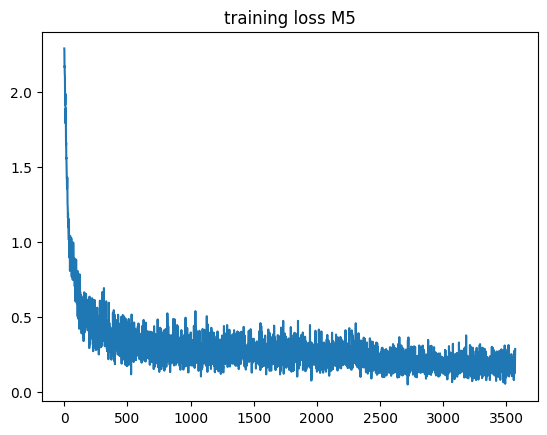

In [35]:
plt.plot(losses);
plt.title("training loss M5");

In [79]:
torch.save(model_m5.state_dict(), 'm5.model')

Обучим M11

In [82]:
optimizer = optim.Adam(model_m11.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

losses = []
accuracy_test = []
losses_test = []
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_m11, optimizer, epoch, log_interval)
        test(model_m11, epoch)
        scheduler.step()

  0%|          | 0.013422818791946308/30 [00:00<13:19, 26.66s/it]

Train Epoch: 1 [0/30441 (0%)]	Loss: 2.342932	Accuracy: 27/30441 (0%)


  0%|          | 0.14765100671140938/30 [00:04<14:27, 29.05s/it]

Train Epoch: 1 [5120/30441 (17%)]	Loss: 0.809217	Accuracy: 3088/30441 (10%)


  1%|          | 0.2818791946308723/30 [00:07<12:32, 25.32s/it] 

Train Epoch: 1 [10240/30441 (34%)]	Loss: 0.466881	Accuracy: 7342/30441 (24%)


  1%|▏         | 0.4161073825503352/30 [00:11<12:35, 25.54s/it] 

Train Epoch: 1 [15360/30441 (50%)]	Loss: 0.377499	Accuracy: 11885/30441 (39%)


  2%|▏         | 0.5503355704697981/30 [00:14<12:46, 26.02s/it]

Train Epoch: 1 [20480/30441 (67%)]	Loss: 0.498140	Accuracy: 16535/30441 (54%)


  2%|▏         | 0.684563758389261/30 [00:18<12:44, 26.09s/it] 

Train Epoch: 1 [25600/30441 (84%)]	Loss: 0.351811	Accuracy: 21245/30441 (70%)


  3%|▎         | 1.006711409395972/30 [00:25<09:09, 18.96s/it] 


Test Epoch: 1 	Loss: 9.248321	Accuracy: 880/7611 (12%)

Train Epoch: 2 [0/30441 (0%)]	Loss: 0.329954	Accuracy: 240/30441 (1%)


  4%|▍         | 1.1476510067114103/30 [00:28<13:53, 28.88s/it]

Train Epoch: 2 [5120/30441 (17%)]	Loss: 0.303321	Accuracy: 5043/30441 (17%)


  4%|▍         | 1.2818791946308754/30 [00:32<12:00, 25.08s/it]

Train Epoch: 2 [10240/30441 (34%)]	Loss: 0.440336	Accuracy: 9812/30441 (32%)


  5%|▍         | 1.4161073825503405/30 [00:35<12:23, 26.03s/it]

Train Epoch: 2 [15360/30441 (50%)]	Loss: 0.356588	Accuracy: 14607/30441 (48%)


  5%|▌         | 1.5503355704698056/30 [00:39<12:04, 25.46s/it]

Train Epoch: 2 [20480/30441 (67%)]	Loss: 0.236923	Accuracy: 19424/30441 (64%)


  6%|▌         | 1.6845637583892707/30 [00:43<12:15, 25.96s/it]

Train Epoch: 2 [25600/30441 (84%)]	Loss: 0.415614	Accuracy: 24268/30441 (80%)


  7%|▋         | 2.006711409395987/30 [00:49<08:26, 18.09s/it] 


Test Epoch: 2 	Loss: 3.916953	Accuracy: 1490/7611 (20%)

Train Epoch: 3 [0/30441 (0%)]	Loss: 0.301643	Accuracy: 242/30441 (1%)


  7%|▋         | 2.1476510067114254/30 [00:53<12:50, 27.66s/it]

Train Epoch: 3 [5120/30441 (17%)]	Loss: 0.282724	Accuracy: 5107/30441 (17%)


  8%|▊         | 2.2818791946308905/30 [00:57<12:20, 26.72s/it]

Train Epoch: 3 [10240/30441 (34%)]	Loss: 0.226027	Accuracy: 9972/30441 (33%)


  8%|▊         | 2.4161073825503556/30 [01:00<12:06, 26.34s/it]

Train Epoch: 3 [15360/30441 (50%)]	Loss: 0.212221	Accuracy: 14833/30441 (49%)


  9%|▊         | 2.5503355704698207/30 [01:04<11:42, 25.60s/it]

Train Epoch: 3 [20480/30441 (67%)]	Loss: 0.274707	Accuracy: 19720/30441 (65%)


  9%|▉         | 2.684563758389286/30 [01:07<11:39, 25.60s/it] 

Train Epoch: 3 [25600/30441 (84%)]	Loss: 0.285820	Accuracy: 24614/30441 (81%)


 10%|█         | 3.006711409396002/30 [01:14<08:12, 18.25s/it] 


Test Epoch: 3 	Loss: 2.685433	Accuracy: 2392/7611 (31%)

Train Epoch: 4 [0/30441 (0%)]	Loss: 0.283705	Accuracy: 239/30441 (1%)


 10%|█         | 3.1476510067114405/30 [01:18<12:31, 27.99s/it]

Train Epoch: 4 [5120/30441 (17%)]	Loss: 0.342394	Accuracy: 5145/30441 (17%)


 11%|█         | 3.2818791946309056/30 [01:21<11:22, 25.54s/it]

Train Epoch: 4 [10240/30441 (34%)]	Loss: 0.244612	Accuracy: 10061/30441 (33%)


 11%|█▏        | 3.4161073825503707/30 [01:25<11:00, 24.83s/it]

Train Epoch: 4 [15360/30441 (50%)]	Loss: 0.163139	Accuracy: 14968/30441 (49%)


 12%|█▏        | 3.550335570469836/30 [01:28<11:28, 26.03s/it] 

Train Epoch: 4 [20480/30441 (67%)]	Loss: 0.289682	Accuracy: 19837/30441 (65%)


 12%|█▏        | 3.684563758389301/30 [01:32<11:19, 25.82s/it] 

Train Epoch: 4 [25600/30441 (84%)]	Loss: 0.273526	Accuracy: 24761/30441 (81%)


 13%|█▎        | 4.006711409396017/30 [01:39<07:57, 18.36s/it] 


Test Epoch: 4 	Loss: 5.222565	Accuracy: 1427/7611 (19%)

Train Epoch: 5 [0/30441 (0%)]	Loss: 0.276635	Accuracy: 243/30441 (1%)


 14%|█▍        | 4.147651006711455/30 [01:43<12:14, 28.39s/it]

Train Epoch: 5 [5120/30441 (17%)]	Loss: 0.163932	Accuracy: 5148/30441 (17%)


 14%|█▍        | 4.28187919463092/30 [01:46<10:48, 25.22s/it] 

Train Epoch: 5 [10240/30441 (34%)]	Loss: 0.128426	Accuracy: 10076/30441 (33%)


 15%|█▍        | 4.416107382550385/30 [01:50<10:55, 25.60s/it]

Train Epoch: 5 [15360/30441 (50%)]	Loss: 0.200647	Accuracy: 14992/30441 (49%)


 15%|█▌        | 4.5503355704698505/30 [01:53<10:40, 25.15s/it]

Train Epoch: 5 [20480/30441 (67%)]	Loss: 0.231857	Accuracy: 19915/30441 (65%)


 16%|█▌        | 4.684563758389316/30 [01:57<10:54, 25.87s/it]

Train Epoch: 5 [25600/30441 (84%)]	Loss: 0.346680	Accuracy: 24804/30441 (81%)


 17%|█▋        | 5.006711409396032/30 [02:04<07:33, 18.14s/it]


Test Epoch: 5 	Loss: 2.868289	Accuracy: 2603/7611 (34%)

Train Epoch: 6 [0/30441 (0%)]	Loss: 0.165424	Accuracy: 249/30441 (1%)


 17%|█▋        | 5.14765100671147/30 [02:07<11:39, 28.15s/it] 

Train Epoch: 6 [5120/30441 (17%)]	Loss: 0.237533	Accuracy: 5188/30441 (17%)


 18%|█▊        | 5.281879194630935/30 [02:11<10:50, 26.30s/it]

Train Epoch: 6 [10240/30441 (34%)]	Loss: 0.261599	Accuracy: 10116/30441 (33%)


 18%|█▊        | 5.4161073825504005/30 [02:15<10:26, 25.50s/it]

Train Epoch: 6 [15360/30441 (50%)]	Loss: 0.262796	Accuracy: 15023/30441 (49%)


 19%|█▊        | 5.550335570469866/30 [02:18<10:04, 24.74s/it]

Train Epoch: 6 [20480/30441 (67%)]	Loss: 0.239452	Accuracy: 19967/30441 (66%)


 19%|█▉        | 5.684563758389331/30 [02:22<10:18, 25.42s/it] 

Train Epoch: 6 [25600/30441 (84%)]	Loss: 0.218174	Accuracy: 24876/30441 (82%)


 20%|██        | 6.006711409396047/30 [02:28<07:24, 18.54s/it] 


Test Epoch: 6 	Loss: 3.163723	Accuracy: 1866/7611 (25%)

Train Epoch: 7 [0/30441 (0%)]	Loss: 0.245235	Accuracy: 244/30441 (1%)


 20%|██        | 6.147651006711485/30 [02:32<11:34, 29.10s/it]

Train Epoch: 7 [5120/30441 (17%)]	Loss: 0.286600	Accuracy: 5160/30441 (17%)


 21%|██        | 6.2818791946309505/30 [02:36<10:13, 25.86s/it]

Train Epoch: 7 [10240/30441 (34%)]	Loss: 0.234244	Accuracy: 10074/30441 (33%)


 21%|██▏       | 6.416107382550416/30 [02:39<10:03, 25.60s/it]

Train Epoch: 7 [15360/30441 (50%)]	Loss: 0.164745	Accuracy: 15012/30441 (49%)


 22%|██▏       | 6.550335570469881/30 [02:43<10:09, 25.99s/it]

Train Epoch: 7 [20480/30441 (67%)]	Loss: 0.181439	Accuracy: 19931/30441 (65%)


 22%|██▏       | 6.684563758389346/30 [02:47<10:01, 25.79s/it] 

Train Epoch: 7 [25600/30441 (84%)]	Loss: 0.165052	Accuracy: 24877/30441 (82%)


 23%|██▎       | 7.006711409396062/30 [02:53<07:36, 19.86s/it]


Test Epoch: 7 	Loss: 3.205006	Accuracy: 2731/7611 (36%)

Train Epoch: 8 [0/30441 (0%)]	Loss: 0.244424	Accuracy: 245/30441 (1%)


 24%|██▍       | 7.1476510067115/30 [02:57<10:56, 28.74s/it]  

Train Epoch: 8 [5120/30441 (17%)]	Loss: 0.170796	Accuracy: 5206/30441 (17%)


 24%|██▍       | 7.281879194630966/30 [03:01<10:00, 26.42s/it]

Train Epoch: 8 [10240/30441 (34%)]	Loss: 0.135204	Accuracy: 10140/30441 (33%)


 25%|██▍       | 7.416107382550431/30 [03:04<09:49, 26.11s/it]

Train Epoch: 8 [15360/30441 (50%)]	Loss: 0.301448	Accuracy: 15082/30441 (50%)


 25%|██▌       | 7.550335570469896/30 [03:08<09:55, 26.54s/it] 

Train Epoch: 8 [20480/30441 (67%)]	Loss: 0.215094	Accuracy: 19994/30441 (66%)


 26%|██▌       | 7.684563758389361/30 [03:12<09:52, 26.57s/it]

Train Epoch: 8 [25600/30441 (84%)]	Loss: 0.243161	Accuracy: 24917/30441 (82%)


 27%|██▋       | 8.006711409396075/30 [03:18<07:05, 19.33s/it]


Test Epoch: 8 	Loss: 0.369254	Accuracy: 6943/7611 (91%)

Train Epoch: 9 [0/30441 (0%)]	Loss: 0.241935	Accuracy: 247/30441 (1%)


 27%|██▋       | 8.147651006711495/30 [03:22<10:30, 28.87s/it]

Train Epoch: 9 [5120/30441 (17%)]	Loss: 0.253715	Accuracy: 5154/30441 (17%)


 28%|██▊       | 8.281879194630942/30 [03:26<09:24, 26.01s/it]

Train Epoch: 9 [10240/30441 (34%)]	Loss: 0.184923	Accuracy: 10086/30441 (33%)


 28%|██▊       | 8.41610738255039/30 [03:29<09:36, 26.72s/it] 

Train Epoch: 9 [15360/30441 (50%)]	Loss: 0.114515	Accuracy: 15040/30441 (49%)


 29%|██▊       | 8.550335570469837/30 [03:33<09:43, 27.21s/it]

Train Epoch: 9 [20480/30441 (67%)]	Loss: 0.148912	Accuracy: 19974/30441 (66%)


 29%|██▉       | 8.684563758389285/30 [03:37<09:10, 25.82s/it]

Train Epoch: 9 [25600/30441 (84%)]	Loss: 0.298725	Accuracy: 24907/30441 (82%)


 30%|███       | 9.006711409395958/30 [03:43<06:16, 17.95s/it]


Test Epoch: 9 	Loss: 4.579781	Accuracy: 1656/7611 (22%)

Train Epoch: 10 [0/30441 (0%)]	Loss: 0.308617	Accuracy: 242/30441 (1%)


 30%|███       | 9.147651006711378/30 [03:47<10:14, 29.49s/it]

Train Epoch: 10 [5120/30441 (17%)]	Loss: 0.242927	Accuracy: 5192/30441 (17%)


 31%|███       | 9.281879194630825/30 [03:51<08:37, 24.98s/it]

Train Epoch: 10 [10240/30441 (34%)]	Loss: 0.312166	Accuracy: 10116/30441 (33%)


 31%|███▏      | 9.416107382550273/30 [03:54<09:04, 26.44s/it]

Train Epoch: 10 [15360/30441 (50%)]	Loss: 0.108191	Accuracy: 15052/30441 (49%)


 32%|███▏      | 9.55033557046972/30 [03:58<09:27, 27.75s/it] 

Train Epoch: 10 [20480/30441 (67%)]	Loss: 0.233693	Accuracy: 19972/30441 (66%)


 32%|███▏      | 9.684563758389167/30 [04:02<08:42, 25.72s/it]

Train Epoch: 10 [25600/30441 (84%)]	Loss: 0.159634	Accuracy: 24935/30441 (82%)


 33%|███▎      | 10.006711409395841/30 [04:08<06:10, 18.53s/it]


Test Epoch: 10 	Loss: 1.273910	Accuracy: 4202/7611 (55%)

Train Epoch: 11 [0/30441 (0%)]	Loss: 0.226677	Accuracy: 243/30441 (1%)


 34%|███▍      | 10.14765100671126/30 [04:12<09:14, 27.93s/it] 

Train Epoch: 11 [5120/30441 (17%)]	Loss: 0.292964	Accuracy: 5169/30441 (17%)


 34%|███▍      | 10.281879194630708/30 [04:16<08:26, 25.67s/it]

Train Epoch: 11 [10240/30441 (34%)]	Loss: 0.190848	Accuracy: 10088/30441 (33%)


 35%|███▍      | 10.416107382550155/30 [04:19<08:19, 25.53s/it]

Train Epoch: 11 [15360/30441 (50%)]	Loss: 0.163377	Accuracy: 15022/30441 (49%)


 35%|███▌      | 10.550335570469603/30 [04:23<09:22, 28.93s/it]

Train Epoch: 11 [20480/30441 (67%)]	Loss: 0.279752	Accuracy: 19961/30441 (66%)


 36%|███▌      | 10.68456375838905/30 [04:27<08:03, 25.03s/it] 

Train Epoch: 11 [25600/30441 (84%)]	Loss: 0.223250	Accuracy: 24884/30441 (82%)


 37%|███▋      | 11.006711409395724/30 [04:33<05:39, 17.88s/it]


Test Epoch: 11 	Loss: 3.113441	Accuracy: 2824/7611 (37%)

Train Epoch: 12 [0/30441 (0%)]	Loss: 0.235117	Accuracy: 245/30441 (1%)


 37%|███▋      | 11.147651006711143/30 [04:37<09:25, 30.00s/it]

Train Epoch: 12 [5120/30441 (17%)]	Loss: 0.185469	Accuracy: 5183/30441 (17%)


 38%|███▊      | 11.28187919463059/30 [04:41<08:17, 26.58s/it] 

Train Epoch: 12 [10240/30441 (34%)]	Loss: 0.158569	Accuracy: 10139/30441 (33%)


 38%|███▊      | 11.416107382550038/30 [04:44<08:04, 26.06s/it]

Train Epoch: 12 [15360/30441 (50%)]	Loss: 0.207785	Accuracy: 15075/30441 (50%)


 39%|███▊      | 11.550335570469485/30 [04:48<08:46, 28.56s/it]

Train Epoch: 12 [20480/30441 (67%)]	Loss: 0.284543	Accuracy: 19998/30441 (66%)


 39%|███▉      | 11.684563758388933/30 [04:52<07:51, 25.73s/it]

Train Epoch: 12 [25600/30441 (84%)]	Loss: 0.302490	Accuracy: 24937/30441 (82%)


 40%|████      | 12.006711409395606/30 [04:58<05:20, 17.83s/it]


Test Epoch: 12 	Loss: 2.751685	Accuracy: 2497/7611 (33%)

Train Epoch: 13 [0/30441 (0%)]	Loss: 0.103723	Accuracy: 250/30441 (1%)


 40%|████      | 12.147651006711026/30 [05:02<08:31, 28.67s/it]

Train Epoch: 13 [5120/30441 (17%)]	Loss: 0.211164	Accuracy: 5203/30441 (17%)


 41%|████      | 12.281879194630474/30 [05:05<07:25, 25.12s/it]

Train Epoch: 13 [10240/30441 (34%)]	Loss: 0.278103	Accuracy: 10141/30441 (33%)


 41%|████▏     | 12.41610738254992/30 [05:09<07:41, 26.25s/it] 

Train Epoch: 13 [15360/30441 (50%)]	Loss: 0.124039	Accuracy: 15068/30441 (49%)


 42%|████▏     | 12.550335570469368/30 [05:13<08:13, 28.30s/it]

Train Epoch: 13 [20480/30441 (67%)]	Loss: 0.164922	Accuracy: 19994/30441 (66%)


 42%|████▏     | 12.684563758388816/30 [05:16<07:28, 25.93s/it]

Train Epoch: 13 [25600/30441 (84%)]	Loss: 0.278271	Accuracy: 24923/30441 (82%)


 43%|████▎     | 13.00671140939549/30 [05:23<05:19, 18.78s/it] 


Test Epoch: 13 	Loss: 2.942778	Accuracy: 2505/7611 (33%)

Train Epoch: 14 [0/30441 (0%)]	Loss: 0.203647	Accuracy: 246/30441 (1%)


 44%|████▍     | 13.147651006710909/30 [05:27<07:44, 27.58s/it]

Train Epoch: 14 [5120/30441 (17%)]	Loss: 0.143617	Accuracy: 5184/30441 (17%)


 44%|████▍     | 13.281879194630356/30 [05:30<07:02, 25.26s/it]

Train Epoch: 14 [10240/30441 (34%)]	Loss: 0.156404	Accuracy: 10105/30441 (33%)


 45%|████▍     | 13.416107382549804/30 [05:34<07:03, 25.54s/it]

Train Epoch: 14 [15360/30441 (50%)]	Loss: 0.219638	Accuracy: 15031/30441 (49%)


 45%|████▌     | 13.550335570469251/30 [05:37<07:45, 28.32s/it]

Train Epoch: 14 [20480/30441 (67%)]	Loss: 0.211826	Accuracy: 19971/30441 (66%)


 46%|████▌     | 13.684563758388698/30 [05:41<06:49, 25.10s/it]

Train Epoch: 14 [25600/30441 (84%)]	Loss: 0.146143	Accuracy: 24925/30441 (82%)


 47%|████▋     | 14.006711409395372/30 [05:48<04:49, 18.09s/it]


Test Epoch: 14 	Loss: 3.585387	Accuracy: 1956/7611 (26%)

Train Epoch: 15 [0/30441 (0%)]	Loss: 0.152757	Accuracy: 247/30441 (1%)


 47%|████▋     | 14.147651006710792/30 [05:52<07:08, 27.05s/it]

Train Epoch: 15 [5120/30441 (17%)]	Loss: 0.205891	Accuracy: 5173/30441 (17%)


 48%|████▊     | 14.281879194630239/30 [05:55<06:42, 25.62s/it]

Train Epoch: 15 [10240/30441 (34%)]	Loss: 0.229963	Accuracy: 10090/30441 (33%)


 48%|████▊     | 14.416107382549686/30 [05:59<06:38, 25.58s/it]

Train Epoch: 15 [15360/30441 (50%)]	Loss: 0.085970	Accuracy: 15042/30441 (49%)


 49%|████▊     | 14.550335570469134/30 [06:02<07:10, 27.85s/it]

Train Epoch: 15 [20480/30441 (67%)]	Loss: 0.239619	Accuracy: 20003/30441 (66%)


 49%|████▉     | 14.684563758388581/30 [06:06<06:33, 25.69s/it]

Train Epoch: 15 [25600/30441 (84%)]	Loss: 0.257375	Accuracy: 24930/30441 (82%)


 50%|█████     | 15.006711409395255/30 [06:13<04:30, 18.07s/it]


Test Epoch: 15 	Loss: 1.959641	Accuracy: 3186/7611 (42%)

Train Epoch: 16 [0/30441 (0%)]	Loss: 0.214497	Accuracy: 246/30441 (1%)


 50%|█████     | 15.147651006710674/30 [06:16<06:38, 26.81s/it]

Train Epoch: 16 [5120/30441 (17%)]	Loss: 0.234648	Accuracy: 5173/30441 (17%)


 51%|█████     | 15.281879194630122/30 [06:20<06:29, 26.48s/it]

Train Epoch: 16 [10240/30441 (34%)]	Loss: 0.171970	Accuracy: 10117/30441 (33%)


 51%|█████▏    | 15.41610738254957/30 [06:23<06:09, 25.37s/it] 

Train Epoch: 16 [15360/30441 (50%)]	Loss: 0.134732	Accuracy: 15048/30441 (49%)


 52%|█████▏    | 15.550335570469016/30 [06:27<06:41, 27.77s/it]

Train Epoch: 16 [20480/30441 (67%)]	Loss: 0.132990	Accuracy: 20012/30441 (66%)


 52%|█████▏    | 15.684563758388464/30 [06:31<06:09, 25.83s/it]

Train Epoch: 16 [25600/30441 (84%)]	Loss: 0.253747	Accuracy: 24966/30441 (82%)


 53%|█████▎    | 16.006711409395137/30 [06:37<04:16, 18.36s/it]


Test Epoch: 16 	Loss: 3.314648	Accuracy: 2262/7611 (30%)

Train Epoch: 17 [0/30441 (0%)]	Loss: 0.165127	Accuracy: 247/30441 (1%)


 54%|█████▍    | 16.147651006710557/30 [06:41<06:22, 27.64s/it]

Train Epoch: 17 [5120/30441 (17%)]	Loss: 0.187067	Accuracy: 5211/30441 (17%)


 54%|█████▍    | 16.281879194630005/30 [06:45<05:55, 25.88s/it]

Train Epoch: 17 [10240/30441 (34%)]	Loss: 0.165256	Accuracy: 10153/30441 (33%)


 55%|█████▍    | 16.416107382549452/30 [06:49<05:44, 25.37s/it]

Train Epoch: 17 [15360/30441 (50%)]	Loss: 0.225406	Accuracy: 15086/30441 (50%)


 55%|█████▌    | 16.5503355704689/30 [06:52<06:13, 27.80s/it]  

Train Epoch: 17 [20480/30441 (67%)]	Loss: 0.237431	Accuracy: 20010/30441 (66%)


 56%|█████▌    | 16.684563758388347/30 [06:56<05:34, 25.09s/it]

Train Epoch: 17 [25600/30441 (84%)]	Loss: 0.163194	Accuracy: 24973/30441 (82%)


 57%|█████▋    | 17.00671140939502/30 [07:03<04:09, 19.20s/it] 


Test Epoch: 17 	Loss: 4.628891	Accuracy: 1503/7611 (20%)

Train Epoch: 18 [0/30441 (0%)]	Loss: 0.172614	Accuracy: 246/30441 (1%)


 57%|█████▋    | 17.14765100671044/30 [07:06<05:29, 25.62s/it] 

Train Epoch: 18 [5120/30441 (17%)]	Loss: 0.151845	Accuracy: 5193/30441 (17%)


 58%|█████▊    | 17.281879194629887/30 [07:10<05:26, 25.67s/it]

Train Epoch: 18 [10240/30441 (34%)]	Loss: 0.201090	Accuracy: 10111/30441 (33%)


 58%|█████▊    | 17.416107382549335/30 [07:13<05:24, 25.75s/it]

Train Epoch: 18 [15360/30441 (50%)]	Loss: 0.229508	Accuracy: 15058/30441 (49%)


 59%|█████▊    | 17.550335570468782/30 [07:17<05:53, 28.42s/it]

Train Epoch: 18 [20480/30441 (67%)]	Loss: 0.133222	Accuracy: 20011/30441 (66%)


 59%|█████▉    | 17.68456375838823/30 [07:21<05:31, 26.94s/it] 

Train Epoch: 18 [25600/30441 (84%)]	Loss: 0.137532	Accuracy: 24966/30441 (82%)


 60%|██████    | 18.006711409394903/30 [07:27<03:37, 18.12s/it]


Test Epoch: 18 	Loss: 2.068181	Accuracy: 3536/7611 (46%)

Train Epoch: 19 [0/30441 (0%)]	Loss: 0.179487	Accuracy: 248/30441 (1%)


 60%|██████    | 18.147651006710323/30 [07:31<05:29, 27.78s/it]

Train Epoch: 19 [5120/30441 (17%)]	Loss: 0.125022	Accuracy: 5212/30441 (17%)


 61%|██████    | 18.28187919462977/30 [07:35<04:59, 25.57s/it] 

Train Epoch: 19 [10240/30441 (34%)]	Loss: 0.206537	Accuracy: 10159/30441 (33%)


 61%|██████▏   | 18.416107382549217/30 [07:38<05:02, 26.12s/it]

Train Epoch: 19 [15360/30441 (50%)]	Loss: 0.148848	Accuracy: 15110/30441 (50%)


 62%|██████▏   | 18.550335570468665/30 [07:42<05:30, 28.87s/it]

Train Epoch: 19 [20480/30441 (67%)]	Loss: 0.196307	Accuracy: 20030/30441 (66%)


 62%|██████▏   | 18.684563758388112/30 [07:46<05:02, 26.69s/it]

Train Epoch: 19 [25600/30441 (84%)]	Loss: 0.180182	Accuracy: 24952/30441 (82%)


 63%|██████▎   | 19.006711409394786/30 [07:52<03:23, 18.52s/it]


Test Epoch: 19 	Loss: 1.559646	Accuracy: 4547/7611 (60%)

Train Epoch: 20 [0/30441 (0%)]	Loss: 0.275664	Accuracy: 242/30441 (1%)


 64%|██████▍   | 19.147651006710205/30 [07:56<04:44, 26.18s/it]

Train Epoch: 20 [5120/30441 (17%)]	Loss: 0.148012	Accuracy: 5197/30441 (17%)


 64%|██████▍   | 19.281879194629653/30 [08:00<04:37, 25.91s/it]

Train Epoch: 20 [10240/30441 (34%)]	Loss: 0.104420	Accuracy: 10152/30441 (33%)


 65%|██████▍   | 19.4161073825491/30 [08:03<04:37, 26.21s/it]  

Train Epoch: 20 [15360/30441 (50%)]	Loss: 0.150435	Accuracy: 15099/30441 (50%)


 65%|██████▌   | 19.550335570468548/30 [08:07<04:59, 28.71s/it]

Train Epoch: 20 [20480/30441 (67%)]	Loss: 0.184790	Accuracy: 20024/30441 (66%)


 66%|██████▌   | 19.684563758387995/30 [08:11<04:23, 25.54s/it]

Train Epoch: 20 [25600/30441 (84%)]	Loss: 0.191669	Accuracy: 24960/30441 (82%)


 67%|██████▋   | 20.00671140939467/30 [08:17<03:13, 19.35s/it] 


Test Epoch: 20 	Loss: 3.115857	Accuracy: 1742/7611 (23%)

Train Epoch: 21 [0/30441 (0%)]	Loss: 0.219503	Accuracy: 245/30441 (1%)


 67%|██████▋   | 20.14765100671009/30 [08:21<04:20, 26.47s/it] 

Train Epoch: 21 [5120/30441 (17%)]	Loss: 0.160574	Accuracy: 5201/30441 (17%)


 68%|██████▊   | 20.281879194629536/30 [08:25<04:06, 25.33s/it]

Train Epoch: 21 [10240/30441 (34%)]	Loss: 0.090611	Accuracy: 10162/30441 (33%)


 68%|██████▊   | 20.416107382548983/30 [08:28<04:16, 26.78s/it]

Train Epoch: 21 [15360/30441 (50%)]	Loss: 0.103859	Accuracy: 15135/30441 (50%)


 69%|██████▊   | 20.55033557046843/30 [08:32<04:19, 27.43s/it] 

Train Epoch: 21 [20480/30441 (67%)]	Loss: 0.150949	Accuracy: 20084/30441 (66%)


 69%|██████▉   | 20.684563758387878/30 [08:36<04:01, 25.97s/it]

Train Epoch: 21 [25600/30441 (84%)]	Loss: 0.130344	Accuracy: 25070/30441 (82%)


 70%|██████▉   | 20.99999999999858/30 [08:42<02:36, 17.37s/it] 


Test Epoch: 21 	Loss: 0.254216	Accuracy: 7018/7611 (92%)



 70%|███████   | 21.013422818790524/30 [08:43<03:18, 22.12s/it]

Train Epoch: 22 [0/30441 (0%)]	Loss: 0.084739	Accuracy: 250/30441 (1%)


 70%|███████   | 21.14765100670997/30 [08:46<03:47, 25.65s/it]

Train Epoch: 22 [5120/30441 (17%)]	Loss: 0.099300	Accuracy: 5235/30441 (17%)


 71%|███████   | 21.28187919462942/30 [08:50<03:44, 25.71s/it] 

Train Epoch: 22 [10240/30441 (34%)]	Loss: 0.075623	Accuracy: 10221/30441 (34%)


 71%|███████▏  | 21.416107382548866/30 [08:53<03:37, 25.36s/it]

Train Epoch: 22 [15360/30441 (50%)]	Loss: 0.114317	Accuracy: 15217/30441 (50%)


 72%|███████▏  | 21.550335570468313/30 [08:57<03:55, 27.84s/it]

Train Epoch: 22 [20480/30441 (67%)]	Loss: 0.112551	Accuracy: 20178/30441 (66%)


 72%|███████▏  | 21.68456375838776/30 [09:00<03:36, 26.01s/it] 

Train Epoch: 22 [25600/30441 (84%)]	Loss: 0.109453	Accuracy: 25152/30441 (83%)


 73%|███████▎  | 22.006711409394434/30 [09:07<02:54, 21.86s/it]


Test Epoch: 22 	Loss: 0.516351	Accuracy: 6272/7611 (82%)

Train Epoch: 23 [0/30441 (0%)]	Loss: 0.099186	Accuracy: 250/30441 (1%)


 74%|███████▍  | 22.147651006709854/30 [09:11<03:20, 25.52s/it]

Train Epoch: 23 [5120/30441 (17%)]	Loss: 0.127778	Accuracy: 5240/30441 (17%)


 74%|███████▍  | 22.2818791946293/30 [09:15<03:20, 25.96s/it] 

Train Epoch: 23 [10240/30441 (34%)]	Loss: 0.096371	Accuracy: 10217/30441 (34%)


 75%|███████▍  | 22.41610738254875/30 [09:18<03:16, 25.90s/it] 

Train Epoch: 23 [15360/30441 (50%)]	Loss: 0.054059	Accuracy: 15209/30441 (50%)


 75%|███████▌  | 22.550335570468196/30 [09:22<03:20, 26.94s/it]

Train Epoch: 23 [20480/30441 (67%)]	Loss: 0.089044	Accuracy: 20164/30441 (66%)


 76%|███████▌  | 22.684563758387643/30 [09:25<03:06, 25.45s/it]

Train Epoch: 23 [25600/30441 (84%)]	Loss: 0.090185	Accuracy: 25144/30441 (83%)


 77%|███████▋  | 23.006711409394317/30 [09:32<02:23, 20.51s/it]


Test Epoch: 23 	Loss: 0.147536	Accuracy: 7285/7611 (96%)

Train Epoch: 24 [0/30441 (0%)]	Loss: 0.058090	Accuracy: 252/30441 (1%)


 77%|███████▋  | 23.147651006709737/30 [09:36<02:51, 25.02s/it]

Train Epoch: 24 [5120/30441 (17%)]	Loss: 0.141750	Accuracy: 5231/30441 (17%)


 78%|███████▊  | 23.281879194629184/30 [09:39<02:51, 25.54s/it]

Train Epoch: 24 [10240/30441 (34%)]	Loss: 0.076862	Accuracy: 10208/30441 (34%)


 78%|███████▊  | 23.41610738254863/30 [09:43<03:03, 27.86s/it]

Train Epoch: 24 [15360/30441 (50%)]	Loss: 0.042199	Accuracy: 15190/30441 (50%)


 79%|███████▊  | 23.55033557046808/30 [09:47<02:55, 27.20s/it] 

Train Epoch: 24 [20480/30441 (67%)]	Loss: 0.101673	Accuracy: 20168/30441 (66%)


 79%|███████▉  | 23.684563758387526/30 [09:50<02:49, 26.82s/it]

Train Epoch: 24 [25600/30441 (84%)]	Loss: 0.112995	Accuracy: 25163/30441 (83%)


 80%|████████  | 24.0067114093942/30 [09:57<02:07, 21.30s/it]  


Test Epoch: 24 	Loss: 0.153905	Accuracy: 7276/7611 (96%)

Train Epoch: 25 [0/30441 (0%)]	Loss: 0.123747	Accuracy: 246/30441 (1%)


 80%|████████  | 24.14765100670962/30 [10:01<02:35, 26.56s/it] 

Train Epoch: 25 [5120/30441 (17%)]	Loss: 0.133986	Accuracy: 5236/30441 (17%)


 81%|████████  | 24.281879194629067/30 [10:04<02:32, 26.71s/it]

Train Epoch: 25 [10240/30441 (34%)]	Loss: 0.126649	Accuracy: 10220/30441 (34%)


 81%|████████▏ | 24.416107382548514/30 [10:08<02:24, 25.88s/it]

Train Epoch: 25 [15360/30441 (50%)]	Loss: 0.068309	Accuracy: 15241/30441 (50%)


 82%|████████▏ | 24.55033557046796/30 [10:12<02:25, 26.67s/it]

Train Epoch: 25 [20480/30441 (67%)]	Loss: 0.081779	Accuracy: 20225/30441 (66%)


 82%|████████▏ | 24.68456375838741/30 [10:15<02:18, 26.01s/it] 

Train Epoch: 25 [25600/30441 (84%)]	Loss: 0.100472	Accuracy: 25205/30441 (83%)


 83%|████████▎ | 25.006711409394082/30 [10:22<01:46, 21.26s/it]


Test Epoch: 25 	Loss: 0.526188	Accuracy: 6510/7611 (86%)

Train Epoch: 26 [0/30441 (0%)]	Loss: 0.047664	Accuracy: 254/30441 (1%)


 84%|████████▍ | 25.147651006709502/30 [10:26<02:07, 26.34s/it]

Train Epoch: 26 [5120/30441 (17%)]	Loss: 0.065759	Accuracy: 5253/30441 (17%)


 84%|████████▍ | 25.28187919462895/30 [10:29<02:02, 26.02s/it] 

Train Epoch: 26 [10240/30441 (34%)]	Loss: 0.070122	Accuracy: 10240/30441 (34%)


 85%|████████▍ | 25.416107382548397/30 [10:33<02:02, 26.79s/it]

Train Epoch: 26 [15360/30441 (50%)]	Loss: 0.062025	Accuracy: 15214/30441 (50%)


 85%|████████▌ | 25.550335570467844/30 [10:37<01:52, 25.29s/it]

Train Epoch: 26 [20480/30441 (67%)]	Loss: 0.102435	Accuracy: 20206/30441 (66%)


 86%|████████▌ | 25.68456375838729/30 [10:40<01:48, 25.09s/it]

Train Epoch: 26 [25600/30441 (84%)]	Loss: 0.180221	Accuracy: 25186/30441 (83%)


 87%|████████▋ | 26.006711409393965/30 [10:47<01:25, 21.38s/it]


Test Epoch: 26 	Loss: 0.229875	Accuracy: 7061/7611 (93%)

Train Epoch: 27 [0/30441 (0%)]	Loss: 0.090906	Accuracy: 251/30441 (1%)


 87%|████████▋ | 26.147651006709385/30 [10:51<01:39, 25.83s/it]

Train Epoch: 27 [5120/30441 (17%)]	Loss: 0.075583	Accuracy: 5250/30441 (17%)


 88%|████████▊ | 26.281879194628832/30 [10:54<01:35, 25.76s/it]

Train Epoch: 27 [10240/30441 (34%)]	Loss: 0.072331	Accuracy: 10239/30441 (34%)


 88%|████████▊ | 26.41610738254828/30 [10:58<01:32, 25.70s/it] 

Train Epoch: 27 [15360/30441 (50%)]	Loss: 0.076516	Accuracy: 15236/30441 (50%)


 89%|████████▊ | 26.550335570467727/30 [11:02<01:30, 26.37s/it]

Train Epoch: 27 [20480/30441 (67%)]	Loss: 0.113666	Accuracy: 20233/30441 (66%)


 89%|████████▉ | 26.684563758387174/30 [11:05<01:25, 25.65s/it]

Train Epoch: 27 [25600/30441 (84%)]	Loss: 0.073926	Accuracy: 25225/30441 (83%)


 90%|█████████ | 27.006711409393848/30 [11:12<01:03, 21.34s/it]


Test Epoch: 27 	Loss: 0.631499	Accuracy: 6272/7611 (82%)

Train Epoch: 28 [0/30441 (0%)]	Loss: 0.044894	Accuracy: 253/30441 (1%)


 90%|█████████ | 27.147651006709268/30 [11:16<01:12, 25.56s/it]

Train Epoch: 28 [5120/30441 (17%)]	Loss: 0.100118	Accuracy: 5259/30441 (17%)


 91%|█████████ | 27.281879194628715/30 [11:19<01:09, 25.68s/it]

Train Epoch: 28 [10240/30441 (34%)]	Loss: 0.100407	Accuracy: 10251/30441 (34%)


 91%|█████████▏| 27.416107382548162/30 [11:23<01:11, 27.76s/it]

Train Epoch: 28 [15360/30441 (50%)]	Loss: 0.092700	Accuracy: 15254/30441 (50%)


 92%|█████████▏| 27.55033557046761/30 [11:26<01:05, 26.54s/it] 

Train Epoch: 28 [20480/30441 (67%)]	Loss: 0.090505	Accuracy: 20250/30441 (67%)


 92%|█████████▏| 27.684563758387057/30 [11:30<01:00, 26.29s/it]

Train Epoch: 28 [25600/30441 (84%)]	Loss: 0.104822	Accuracy: 25247/30441 (83%)


 93%|█████████▎| 28.00671140939373/30 [11:37<00:41, 20.98s/it]


Test Epoch: 28 	Loss: 0.460382	Accuracy: 6647/7611 (87%)

Train Epoch: 29 [0/30441 (0%)]	Loss: 0.048716	Accuracy: 253/30441 (1%)


 94%|█████████▍| 28.14765100670915/30 [11:41<00:46, 24.94s/it] 

Train Epoch: 29 [5120/30441 (17%)]	Loss: 0.094468	Accuracy: 5268/30441 (17%)


 94%|█████████▍| 28.281879194628598/30 [11:44<00:43, 25.39s/it]

Train Epoch: 29 [10240/30441 (34%)]	Loss: 0.084438	Accuracy: 10272/30441 (34%)


 95%|█████████▍| 28.416107382548045/30 [11:48<00:44, 28.11s/it]

Train Epoch: 29 [15360/30441 (50%)]	Loss: 0.103970	Accuracy: 15280/30441 (50%)


 95%|█████████▌| 28.550335570467492/30 [11:51<00:38, 26.61s/it]

Train Epoch: 29 [20480/30441 (67%)]	Loss: 0.065503	Accuracy: 20280/30441 (67%)


 96%|█████████▌| 28.68456375838694/30 [11:55<00:33, 25.47s/it] 

Train Epoch: 29 [25600/30441 (84%)]	Loss: 0.070643	Accuracy: 25278/30441 (83%)


 97%|█████████▋| 29.006711409393613/30 [12:02<00:21, 21.48s/it]


Test Epoch: 29 	Loss: 0.159064	Accuracy: 7231/7611 (95%)

Train Epoch: 30 [0/30441 (0%)]	Loss: 0.058611	Accuracy: 249/30441 (1%)


 97%|█████████▋| 29.147651006709033/30 [12:06<00:21, 25.47s/it]

Train Epoch: 30 [5120/30441 (17%)]	Loss: 0.041280	Accuracy: 5263/30441 (17%)


 98%|█████████▊| 29.28187919462848/30 [12:09<00:18, 25.45s/it] 

Train Epoch: 30 [10240/30441 (34%)]	Loss: 0.077491	Accuracy: 10283/30441 (34%)


 98%|█████████▊| 29.416107382547928/30 [12:13<00:16, 28.46s/it]

Train Epoch: 30 [15360/30441 (50%)]	Loss: 0.044334	Accuracy: 15295/30441 (50%)


 99%|█████████▊| 29.550335570467375/30 [12:16<00:11, 26.35s/it]

Train Epoch: 30 [20480/30441 (67%)]	Loss: 0.066186	Accuracy: 20286/30441 (67%)


 99%|█████████▉| 29.684563758386822/30 [12:20<00:08, 26.80s/it]

Train Epoch: 30 [25600/30441 (84%)]	Loss: 0.086995	Accuracy: 25287/30441 (83%)


100%|█████████▉| 29.999999999997524/30 [12:27<00:00, 24.91s/it]


Test Epoch: 30 	Loss: 0.189547	Accuracy: 7198/7611 (95%)



In [22]:
optimizer = optim.Adam(model_m11.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

losses = []
accuracy_test = []
losses_test = []
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_m11, optimizer, epoch, log_interval)
        test(model_m11, epoch)
        scheduler.step()

  0%|          | 0.013422818791946308/30 [00:08<4:18:42, 517.64s/it]  

Train Epoch: 1 [0/30441 (0%)]	Loss: 2.329113	Accuracy: 24/30441 (0%)


  0%|          | 0.14765100671140938/30 [00:11<12:50, 25.80s/it]

Train Epoch: 1 [5120/30441 (17%)]	Loss: 1.571109	Accuracy: 1215/30441 (4%)


  1%|          | 0.2818791946308723/30 [00:15<12:11, 24.60s/it] 

Train Epoch: 1 [10240/30441 (34%)]	Loss: 0.939409	Accuracy: 4232/30441 (14%)


  1%|▏         | 0.4161073825503352/30 [00:18<13:11, 26.74s/it] 

Train Epoch: 1 [15360/30441 (50%)]	Loss: 0.621479	Accuracy: 8195/30441 (27%)


  2%|▏         | 0.5503355704697981/30 [00:22<13:52, 28.26s/it]

Train Epoch: 1 [20480/30441 (67%)]	Loss: 0.525400	Accuracy: 12343/30441 (41%)


  2%|▏         | 0.684563758389261/30 [00:26<11:50, 24.24s/it] 

Train Epoch: 1 [25600/30441 (84%)]	Loss: 0.660900	Accuracy: 16662/30441 (55%)


  3%|▎         | 1.006711409395972/30 [00:33<10:05, 20.88s/it] 


Test Epoch: 1 	Loss: 8.695287	Accuracy: 812/7611 (11%)

Train Epoch: 2 [0/30441 (0%)]	Loss: 0.527174	Accuracy: 217/30441 (1%)


  4%|▍         | 1.1476510067114103/30 [00:36<11:40, 24.28s/it]

Train Epoch: 2 [5120/30441 (17%)]	Loss: 0.579110	Accuracy: 4665/30441 (15%)


  4%|▍         | 1.2818791946308754/30 [00:40<11:32, 24.10s/it]

Train Epoch: 2 [10240/30441 (34%)]	Loss: 0.441838	Accuracy: 9257/30441 (30%)


  5%|▍         | 1.4161073825503405/30 [00:43<12:30, 26.26s/it]

Train Epoch: 2 [15360/30441 (50%)]	Loss: 0.478400	Accuracy: 13873/30441 (46%)


  5%|▌         | 1.5503355704698056/30 [00:47<12:04, 25.45s/it]

Train Epoch: 2 [20480/30441 (67%)]	Loss: 0.314367	Accuracy: 18549/30441 (61%)


  6%|▌         | 1.6845637583892707/30 [00:50<11:44, 24.87s/it]

Train Epoch: 2 [25600/30441 (84%)]	Loss: 0.258527	Accuracy: 23229/30441 (76%)


  7%|▋         | 2.006711409395987/30 [00:56<09:42, 20.81s/it] 


Test Epoch: 2 	Loss: 13.391056	Accuracy: 960/7611 (13%)

Train Epoch: 3 [0/30441 (0%)]	Loss: 0.493881	Accuracy: 231/30441 (1%)


  7%|▋         | 2.1476510067114254/30 [01:00<11:37, 25.06s/it]

Train Epoch: 3 [5120/30441 (17%)]	Loss: 0.309985	Accuracy: 4933/30441 (16%)


  8%|▊         | 2.2818791946308905/30 [01:03<11:37, 25.17s/it]

Train Epoch: 3 [10240/30441 (34%)]	Loss: 0.456956	Accuracy: 9579/30441 (31%)


  8%|▊         | 2.4161073825503556/30 [01:07<11:04, 24.08s/it]

Train Epoch: 3 [15360/30441 (50%)]	Loss: 0.394485	Accuracy: 14268/30441 (47%)


  9%|▊         | 2.5503355704698207/30 [01:10<11:39, 25.47s/it]

Train Epoch: 3 [20480/30441 (67%)]	Loss: 0.266371	Accuracy: 18989/30441 (62%)


  9%|▉         | 2.684563758389286/30 [01:14<10:57, 24.09s/it] 

Train Epoch: 3 [25600/30441 (84%)]	Loss: 0.331464	Accuracy: 23676/30441 (78%)


 10%|█         | 3.006711409396002/30 [01:20<08:12, 18.26s/it] 


Test Epoch: 3 	Loss: 18.956356	Accuracy: 774/7611 (10%)

Train Epoch: 4 [0/30441 (0%)]	Loss: 0.425210	Accuracy: 231/30441 (1%)


 10%|█         | 3.1476510067114405/30 [01:24<10:58, 24.52s/it]

Train Epoch: 4 [5120/30441 (17%)]	Loss: 0.271492	Accuracy: 5031/30441 (17%)


 11%|█         | 3.2818791946309056/30 [01:27<10:58, 24.65s/it]

Train Epoch: 4 [10240/30441 (34%)]	Loss: 0.328142	Accuracy: 9817/30441 (32%)


 11%|█▏        | 3.4161073825503707/30 [01:31<11:06, 25.06s/it]

Train Epoch: 4 [15360/30441 (50%)]	Loss: 0.366642	Accuracy: 14593/30441 (48%)


 12%|█▏        | 3.550335570469836/30 [01:34<12:06, 27.48s/it] 

Train Epoch: 4 [20480/30441 (67%)]	Loss: 0.444917	Accuracy: 19347/30441 (64%)


 12%|█▏        | 3.684563758389301/30 [01:38<10:58, 25.01s/it] 

Train Epoch: 4 [25600/30441 (84%)]	Loss: 0.366857	Accuracy: 24144/30441 (79%)


 13%|█▎        | 4.006711409396017/30 [01:44<07:27, 17.23s/it] 


Test Epoch: 4 	Loss: 2.367594	Accuracy: 2169/7611 (28%)

Train Epoch: 5 [0/30441 (0%)]	Loss: 0.335194	Accuracy: 243/30441 (1%)


 14%|█▍        | 4.147651006711455/30 [01:48<11:27, 26.58s/it]

Train Epoch: 5 [5120/30441 (17%)]	Loss: 0.241546	Accuracy: 5051/30441 (17%)


 14%|█▍        | 4.28187919463092/30 [01:51<10:22, 24.19s/it] 

Train Epoch: 5 [10240/30441 (34%)]	Loss: 0.466806	Accuracy: 9879/30441 (32%)


 15%|█▍        | 4.416107382550385/30 [01:54<10:46, 25.26s/it]

Train Epoch: 5 [15360/30441 (50%)]	Loss: 0.277637	Accuracy: 14694/30441 (48%)


 15%|█▌        | 4.5503355704698505/30 [01:58<11:25, 26.92s/it]

Train Epoch: 5 [20480/30441 (67%)]	Loss: 0.174705	Accuracy: 19531/30441 (64%)


 16%|█▌        | 4.684563758389316/30 [02:02<10:38, 25.23s/it]

Train Epoch: 5 [25600/30441 (84%)]	Loss: 0.308592	Accuracy: 24324/30441 (80%)


 17%|█▋        | 5.006711409396032/30 [02:08<07:17, 17.50s/it]


Test Epoch: 5 	Loss: 2.813860	Accuracy: 2126/7611 (28%)

Train Epoch: 6 [0/30441 (0%)]	Loss: 0.347825	Accuracy: 243/30441 (1%)


 17%|█▋        | 5.14765100671147/30 [02:12<11:07, 26.86s/it] 

Train Epoch: 6 [5120/30441 (17%)]	Loss: 0.287649	Accuracy: 5086/30441 (17%)


 18%|█▊        | 5.281879194630935/30 [02:15<10:24, 25.25s/it]

Train Epoch: 6 [10240/30441 (34%)]	Loss: 0.232986	Accuracy: 9905/30441 (33%)


 18%|█▊        | 5.4161073825504005/30 [02:19<10:26, 25.49s/it]

Train Epoch: 6 [15360/30441 (50%)]	Loss: 0.349768	Accuracy: 14749/30441 (48%)


 19%|█▊        | 5.550335570469866/30 [02:22<09:48, 24.09s/it]

Train Epoch: 6 [20480/30441 (67%)]	Loss: 0.237788	Accuracy: 19575/30441 (64%)


 19%|█▉        | 5.684563758389331/30 [02:26<10:28, 25.85s/it] 

Train Epoch: 6 [25600/30441 (84%)]	Loss: 0.342538	Accuracy: 24405/30441 (80%)


 20%|██        | 6.006711409396047/30 [02:32<07:00, 17.52s/it] 


Test Epoch: 6 	Loss: 4.946939	Accuracy: 843/7611 (11%)

Train Epoch: 7 [0/30441 (0%)]	Loss: 0.289703	Accuracy: 243/30441 (1%)


 20%|██        | 6.147651006711485/30 [02:35<10:30, 26.44s/it]

Train Epoch: 7 [5120/30441 (17%)]	Loss: 0.434149	Accuracy: 5059/30441 (17%)


 21%|██        | 6.2818791946309505/30 [02:39<09:24, 23.81s/it]

Train Epoch: 7 [10240/30441 (34%)]	Loss: 0.391711	Accuracy: 9912/30441 (33%)


 21%|██▏       | 6.416107382550416/30 [02:42<09:51, 25.08s/it]

Train Epoch: 7 [15360/30441 (50%)]	Loss: 0.328652	Accuracy: 14798/30441 (49%)


 22%|██▏       | 6.550335570469881/30 [02:46<09:34, 24.51s/it]

Train Epoch: 7 [20480/30441 (67%)]	Loss: 0.270483	Accuracy: 19648/30441 (65%)


 22%|██▏       | 6.684563758389346/30 [02:49<10:16, 26.45s/it] 

Train Epoch: 7 [25600/30441 (84%)]	Loss: 0.310332	Accuracy: 24529/30441 (81%)


 23%|██▎       | 7.006711409396062/30 [02:56<06:43, 17.54s/it]


Test Epoch: 7 	Loss: 4.811181	Accuracy: 1022/7611 (13%)

Train Epoch: 8 [0/30441 (0%)]	Loss: 0.201775	Accuracy: 247/30441 (1%)


 24%|██▍       | 7.1476510067115/30 [02:59<09:35, 25.19s/it]  

Train Epoch: 8 [5120/30441 (17%)]	Loss: 0.260571	Accuracy: 5125/30441 (17%)


 24%|██▍       | 7.281879194630966/30 [03:03<09:32, 25.18s/it]

Train Epoch: 8 [10240/30441 (34%)]	Loss: 0.242486	Accuracy: 10009/30441 (33%)


 25%|██▍       | 7.416107382550431/30 [03:06<09:09, 24.31s/it]

Train Epoch: 8 [15360/30441 (50%)]	Loss: 0.205514	Accuracy: 14902/30441 (49%)


 25%|██▌       | 7.550335570469896/30 [03:10<09:29, 25.36s/it] 

Train Epoch: 8 [20480/30441 (67%)]	Loss: 0.277146	Accuracy: 19782/30441 (65%)


 26%|██▌       | 7.684563758389361/30 [03:13<09:52, 26.55s/it]

Train Epoch: 8 [25600/30441 (84%)]	Loss: 0.260635	Accuracy: 24676/30441 (81%)


 27%|██▋       | 8.006711409396075/30 [03:19<06:13, 16.98s/it]


Test Epoch: 8 	Loss: 4.854444	Accuracy: 1627/7611 (21%)

Train Epoch: 9 [0/30441 (0%)]	Loss: 0.315615	Accuracy: 243/30441 (1%)


 27%|██▋       | 8.147651006711495/30 [03:23<08:52, 24.37s/it]

Train Epoch: 9 [5120/30441 (17%)]	Loss: 0.348653	Accuracy: 5110/30441 (17%)


 28%|██▊       | 8.281879194630942/30 [03:27<10:08, 28.02s/it]

Train Epoch: 9 [10240/30441 (34%)]	Loss: 0.300706	Accuracy: 9990/30441 (33%)


 28%|██▊       | 8.41610738255039/30 [03:30<08:45, 24.36s/it] 

Train Epoch: 9 [15360/30441 (50%)]	Loss: 0.271570	Accuracy: 14848/30441 (49%)


 29%|██▊       | 8.550335570469837/30 [03:34<08:38, 24.17s/it]

Train Epoch: 9 [20480/30441 (67%)]	Loss: 0.273460	Accuracy: 19738/30441 (65%)


 29%|██▉       | 8.684563758389285/30 [03:37<08:58, 25.27s/it]

Train Epoch: 9 [25600/30441 (84%)]	Loss: 0.247457	Accuracy: 24653/30441 (81%)


 30%|███       | 9.006711409395958/30 [03:43<06:00, 17.18s/it]


Test Epoch: 9 	Loss: 1.556777	Accuracy: 3412/7611 (45%)

Train Epoch: 10 [0/30441 (0%)]	Loss: 0.357851	Accuracy: 239/30441 (1%)


 30%|███       | 9.147651006711378/30 [03:47<08:21, 24.03s/it]

Train Epoch: 10 [5120/30441 (17%)]	Loss: 0.177985	Accuracy: 5155/30441 (17%)


 31%|███       | 9.281879194630825/30 [03:50<09:00, 26.07s/it]

Train Epoch: 10 [10240/30441 (34%)]	Loss: 0.208381	Accuracy: 10063/30441 (33%)


 31%|███▏      | 9.416107382550273/30 [03:54<08:36, 25.09s/it]

Train Epoch: 10 [15360/30441 (50%)]	Loss: 0.374722	Accuracy: 14949/30441 (49%)


 32%|███▏      | 9.55033557046972/30 [03:57<08:29, 24.91s/it] 

Train Epoch: 10 [20480/30441 (67%)]	Loss: 0.183204	Accuracy: 19838/30441 (65%)


 32%|███▏      | 9.684563758389167/30 [04:01<08:48, 26.01s/it]

Train Epoch: 10 [25600/30441 (84%)]	Loss: 0.253010	Accuracy: 24721/30441 (81%)


 33%|███▎      | 10.006711409395841/30 [04:07<05:45, 17.28s/it]


Test Epoch: 10 	Loss: 1.911295	Accuracy: 2951/7611 (39%)

Train Epoch: 11 [0/30441 (0%)]	Loss: 0.219596	Accuracy: 246/30441 (1%)


 34%|███▍      | 10.14765100671126/30 [04:11<08:14, 24.89s/it] 

Train Epoch: 11 [5120/30441 (17%)]	Loss: 0.285160	Accuracy: 5138/30441 (17%)


 34%|███▍      | 10.281879194630708/30 [04:14<07:59, 24.31s/it]

Train Epoch: 11 [10240/30441 (34%)]	Loss: 0.230614	Accuracy: 10023/30441 (33%)


 35%|███▍      | 10.416107382550155/30 [04:18<08:02, 24.65s/it]

Train Epoch: 11 [15360/30441 (50%)]	Loss: 0.352244	Accuracy: 14913/30441 (49%)


 35%|███▌      | 10.550335570469603/30 [04:21<08:10, 25.22s/it]

Train Epoch: 11 [20480/30441 (67%)]	Loss: 0.320025	Accuracy: 19801/30441 (65%)


 36%|███▌      | 10.68456375838905/30 [04:25<07:52, 24.46s/it] 

Train Epoch: 11 [25600/30441 (84%)]	Loss: 0.265136	Accuracy: 24678/30441 (81%)


 37%|███▋      | 11.006711409395724/30 [04:31<05:23, 17.03s/it]


Test Epoch: 11 	Loss: 3.140673	Accuracy: 1740/7611 (23%)

Train Epoch: 12 [0/30441 (0%)]	Loss: 0.256710	Accuracy: 247/30441 (1%)


 37%|███▋      | 11.147651006711143/30 [04:35<07:39, 24.36s/it]

Train Epoch: 12 [5120/30441 (17%)]	Loss: 0.151373	Accuracy: 5145/30441 (17%)


 38%|███▊      | 11.28187919463059/30 [04:38<07:34, 24.27s/it] 

Train Epoch: 12 [10240/30441 (34%)]	Loss: 0.250469	Accuracy: 10045/30441 (33%)


 38%|███▊      | 11.416107382550038/30 [04:42<08:28, 27.37s/it]

Train Epoch: 12 [15360/30441 (50%)]	Loss: 0.191305	Accuracy: 14958/30441 (49%)


 39%|███▊      | 11.550335570469485/30 [04:45<07:29, 24.38s/it]

Train Epoch: 12 [20480/30441 (67%)]	Loss: 0.296236	Accuracy: 19874/30441 (65%)


 39%|███▉      | 11.684563758388933/30 [04:49<07:24, 24.25s/it]

Train Epoch: 12 [25600/30441 (84%)]	Loss: 0.178426	Accuracy: 24775/30441 (81%)


 40%|████      | 12.006711409395606/30 [04:56<05:21, 17.89s/it]


Test Epoch: 12 	Loss: 5.645837	Accuracy: 1137/7611 (15%)

Train Epoch: 13 [0/30441 (0%)]	Loss: 0.183964	Accuracy: 245/30441 (1%)


 40%|████      | 12.147651006711026/30 [04:59<07:32, 25.33s/it]

Train Epoch: 13 [5120/30441 (17%)]	Loss: 0.259569	Accuracy: 5120/30441 (17%)


 41%|████      | 12.281879194630474/30 [05:02<07:21, 24.91s/it]

Train Epoch: 13 [10240/30441 (34%)]	Loss: 0.336825	Accuracy: 10023/30441 (33%)


 41%|████▏     | 12.41610738254992/30 [05:06<07:58, 27.22s/it] 

Train Epoch: 13 [15360/30441 (50%)]	Loss: 0.252533	Accuracy: 14940/30441 (49%)


 42%|████▏     | 12.550335570469368/30 [05:10<07:03, 24.27s/it]

Train Epoch: 13 [20480/30441 (67%)]	Loss: 0.260894	Accuracy: 19856/30441 (65%)


 42%|████▏     | 12.684563758388816/30 [05:13<07:21, 25.49s/it]

Train Epoch: 13 [25600/30441 (84%)]	Loss: 0.273119	Accuracy: 24766/30441 (81%)


 43%|████▎     | 13.00671140939549/30 [05:20<05:50, 20.62s/it] 


Test Epoch: 13 	Loss: 6.362815	Accuracy: 1185/7611 (16%)

Train Epoch: 14 [0/30441 (0%)]	Loss: 0.290792	Accuracy: 245/30441 (1%)


 44%|████▍     | 13.147651006710909/30 [05:23<07:01, 25.03s/it]

Train Epoch: 14 [5120/30441 (17%)]	Loss: 0.310116	Accuracy: 5165/30441 (17%)


 44%|████▍     | 13.281879194630356/30 [05:27<07:03, 25.30s/it]

Train Epoch: 14 [10240/30441 (34%)]	Loss: 0.275137	Accuracy: 10050/30441 (33%)


 45%|████▍     | 13.416107382549804/30 [05:30<07:26, 26.94s/it]

Train Epoch: 14 [15360/30441 (50%)]	Loss: 0.191067	Accuracy: 14963/30441 (49%)


 45%|████▌     | 13.550335570469251/30 [05:34<06:56, 25.33s/it]

Train Epoch: 14 [20480/30441 (67%)]	Loss: 0.270876	Accuracy: 19885/30441 (65%)


 46%|████▌     | 13.684563758388698/30 [05:37<06:48, 25.07s/it]

Train Epoch: 14 [25600/30441 (84%)]	Loss: 0.268999	Accuracy: 24802/30441 (81%)


 47%|████▋     | 13.993288590603427/30 [05:44<05:04, 19.04s/it]


Test Epoch: 14 	Loss: 5.410007	Accuracy: 1017/7611 (13%)



 47%|████▋     | 14.013422818791344/30 [05:44<05:34, 20.94s/it]

Train Epoch: 15 [0/30441 (0%)]	Loss: 0.212941	Accuracy: 248/30441 (1%)


 47%|████▋     | 14.147651006710792/30 [05:47<06:37, 25.07s/it]

Train Epoch: 15 [5120/30441 (17%)]	Loss: 0.333799	Accuracy: 5164/30441 (17%)


 48%|████▊     | 14.281879194630239/30 [05:51<06:22, 24.36s/it]

Train Epoch: 15 [10240/30441 (34%)]	Loss: 0.148007	Accuracy: 10078/30441 (33%)


 48%|████▊     | 14.416107382549686/30 [05:54<06:18, 24.27s/it]

Train Epoch: 15 [15360/30441 (50%)]	Loss: 0.367924	Accuracy: 14959/30441 (49%)


 49%|████▊     | 14.550335570469134/30 [05:58<06:15, 24.32s/it]

Train Epoch: 15 [20480/30441 (67%)]	Loss: 0.213088	Accuracy: 19873/30441 (65%)


 49%|████▉     | 14.684563758388581/30 [06:01<06:38, 26.01s/it]

Train Epoch: 15 [25600/30441 (84%)]	Loss: 0.302638	Accuracy: 24779/30441 (81%)


 50%|█████     | 15.006711409395255/30 [06:08<05:10, 20.70s/it]


Test Epoch: 15 	Loss: 2.255322	Accuracy: 2892/7611 (38%)

Train Epoch: 16 [0/30441 (0%)]	Loss: 0.144160	Accuracy: 250/30441 (1%)


 50%|█████     | 15.147651006710674/30 [06:11<06:23, 25.82s/it]

Train Epoch: 16 [5120/30441 (17%)]	Loss: 0.282908	Accuracy: 5159/30441 (17%)


 51%|█████     | 15.281879194630122/30 [06:15<06:00, 24.51s/it]

Train Epoch: 16 [10240/30441 (34%)]	Loss: 0.269482	Accuracy: 10076/30441 (33%)


 51%|█████▏    | 15.41610738254957/30 [06:18<05:56, 24.47s/it] 

Train Epoch: 16 [15360/30441 (50%)]	Loss: 0.266409	Accuracy: 15002/30441 (49%)


 52%|█████▏    | 15.550335570469016/30 [06:22<06:34, 27.32s/it]

Train Epoch: 16 [20480/30441 (67%)]	Loss: 0.213500	Accuracy: 19910/30441 (65%)


 52%|█████▏    | 15.684563758388464/30 [06:25<05:51, 24.58s/it]

Train Epoch: 16 [25600/30441 (84%)]	Loss: 0.277435	Accuracy: 24824/30441 (82%)


 53%|█████▎    | 16.006711409395137/30 [06:32<04:09, 17.80s/it]


Test Epoch: 16 	Loss: 2.206283	Accuracy: 2684/7611 (35%)

Train Epoch: 17 [0/30441 (0%)]	Loss: 0.314927	Accuracy: 241/30441 (1%)


 54%|█████▍    | 16.147651006710557/30 [06:35<05:41, 24.63s/it]

Train Epoch: 17 [5120/30441 (17%)]	Loss: 0.219059	Accuracy: 5167/30441 (17%)


 54%|█████▍    | 16.281879194630005/30 [06:39<05:37, 24.58s/it]

Train Epoch: 17 [10240/30441 (34%)]	Loss: 0.245023	Accuracy: 10091/30441 (33%)


 55%|█████▍    | 16.416107382549452/30 [06:42<05:29, 24.25s/it]

Train Epoch: 17 [15360/30441 (50%)]	Loss: 0.340224	Accuracy: 14987/30441 (49%)


 55%|█████▌    | 16.5503355704689/30 [06:46<06:07, 27.32s/it]  

Train Epoch: 17 [20480/30441 (67%)]	Loss: 0.247832	Accuracy: 19915/30441 (65%)


 56%|█████▌    | 16.684563758388347/30 [06:49<05:20, 24.10s/it]

Train Epoch: 17 [25600/30441 (84%)]	Loss: 0.217626	Accuracy: 24806/30441 (81%)


 57%|█████▋    | 17.00671140939502/30 [06:55<03:39, 16.93s/it] 


Test Epoch: 17 	Loss: 4.503761	Accuracy: 1350/7611 (18%)

Train Epoch: 18 [0/30441 (0%)]	Loss: 0.115362	Accuracy: 251/30441 (1%)


 57%|█████▋    | 17.14765100671044/30 [06:59<05:53, 27.54s/it] 

Train Epoch: 18 [5120/30441 (17%)]	Loss: 0.188092	Accuracy: 5179/30441 (17%)


 58%|█████▊    | 17.281879194629887/30 [07:03<05:16, 24.91s/it]

Train Epoch: 18 [10240/30441 (34%)]	Loss: 0.164955	Accuracy: 10095/30441 (33%)


 58%|█████▊    | 17.416107382549335/30 [07:06<05:10, 24.69s/it]

Train Epoch: 18 [15360/30441 (50%)]	Loss: 0.231630	Accuracy: 15020/30441 (49%)


 59%|█████▊    | 17.550335570468782/30 [07:09<05:14, 25.25s/it]

Train Epoch: 18 [20480/30441 (67%)]	Loss: 0.250028	Accuracy: 19947/30441 (66%)


 59%|█████▉    | 17.68456375838823/30 [07:13<05:05, 24.82s/it] 

Train Epoch: 18 [25600/30441 (84%)]	Loss: 0.293127	Accuracy: 24869/30441 (82%)


 60%|██████    | 18.006711409394903/30 [07:19<03:30, 17.52s/it]


Test Epoch: 18 	Loss: 2.692699	Accuracy: 2141/7611 (28%)

Train Epoch: 19 [0/30441 (0%)]	Loss: 0.208772	Accuracy: 248/30441 (1%)


 60%|██████    | 18.147651006710323/30 [07:23<05:24, 27.40s/it]

Train Epoch: 19 [5120/30441 (17%)]	Loss: 0.247628	Accuracy: 5153/30441 (17%)


 61%|██████    | 18.28187919462977/30 [07:26<04:41, 24.05s/it] 

Train Epoch: 19 [10240/30441 (34%)]	Loss: 0.200891	Accuracy: 10084/30441 (33%)


 61%|██████▏   | 18.416107382549217/30 [07:30<04:59, 25.88s/it]

Train Epoch: 19 [15360/30441 (50%)]	Loss: 0.315120	Accuracy: 14987/30441 (49%)


 62%|██████▏   | 18.550335570468665/30 [07:33<04:36, 24.18s/it]

Train Epoch: 19 [20480/30441 (67%)]	Loss: 0.229157	Accuracy: 19895/30441 (65%)


 62%|██████▏   | 18.684563758388112/30 [07:37<05:00, 26.53s/it]

Train Epoch: 19 [25600/30441 (84%)]	Loss: 0.276797	Accuracy: 24771/30441 (81%)


 63%|██████▎   | 19.006711409394786/30 [07:43<03:13, 17.57s/it]


Test Epoch: 19 	Loss: 4.044105	Accuracy: 1448/7611 (19%)

Train Epoch: 20 [0/30441 (0%)]	Loss: 0.291841	Accuracy: 243/30441 (1%)


 64%|██████▍   | 19.147651006710205/30 [07:47<04:31, 25.01s/it]

Train Epoch: 20 [5120/30441 (17%)]	Loss: 0.280364	Accuracy: 5126/30441 (17%)


 64%|██████▍   | 19.281879194629653/30 [07:50<04:35, 25.68s/it]

Train Epoch: 20 [10240/30441 (34%)]	Loss: 0.280140	Accuracy: 10047/30441 (33%)


 65%|██████▍   | 19.4161073825491/30 [07:54<04:20, 24.65s/it]  

Train Epoch: 20 [15360/30441 (50%)]	Loss: 0.168180	Accuracy: 14986/30441 (49%)


 65%|██████▌   | 19.550335570468548/30 [07:57<04:21, 25.06s/it]

Train Epoch: 20 [20480/30441 (67%)]	Loss: 0.201575	Accuracy: 19890/30441 (65%)


 66%|██████▌   | 19.684563758387995/30 [08:01<04:32, 26.37s/it]

Train Epoch: 20 [25600/30441 (84%)]	Loss: 0.155172	Accuracy: 24810/30441 (82%)


 67%|██████▋   | 19.999999999998696/30 [08:07<02:25, 14.58s/it]


Test Epoch: 20 	Loss: 8.610854	Accuracy: 764/7611 (10%)

Train Epoch: 21 [0/30441 (0%)]	Loss: 0.263964	Accuracy: 243/30441 (1%)


 67%|██████▋   | 20.14765100671009/30 [08:11<03:57, 24.13s/it] 

Train Epoch: 21 [5120/30441 (17%)]	Loss: 0.232274	Accuracy: 5160/30441 (17%)


 68%|██████▊   | 20.281879194629536/30 [08:14<04:42, 29.03s/it]

Train Epoch: 21 [10240/30441 (34%)]	Loss: 0.168523	Accuracy: 10118/30441 (33%)


 68%|██████▊   | 20.416107382548983/30 [08:18<03:55, 24.56s/it]

Train Epoch: 21 [15360/30441 (50%)]	Loss: 0.311704	Accuracy: 15075/30441 (50%)


 69%|██████▊   | 20.55033557046843/30 [08:21<03:43, 23.69s/it] 

Train Epoch: 21 [20480/30441 (67%)]	Loss: 0.202758	Accuracy: 19995/30441 (66%)


 69%|██████▉   | 20.684563758387878/30 [08:24<03:49, 24.68s/it]

Train Epoch: 21 [25600/30441 (84%)]	Loss: 0.152110	Accuracy: 24939/30441 (82%)


 70%|███████   | 21.00671140939455/30 [08:31<02:31, 16.90s/it] 


Test Epoch: 21 	Loss: 1.290035	Accuracy: 4360/7611 (57%)

Train Epoch: 22 [0/30441 (0%)]	Loss: 0.174456	Accuracy: 249/30441 (1%)


 70%|███████   | 21.14765100670997/30 [08:34<03:42, 25.17s/it]

Train Epoch: 22 [5120/30441 (17%)]	Loss: 0.142921	Accuracy: 5185/30441 (17%)


 71%|███████   | 21.28187919462942/30 [08:38<04:03, 27.92s/it] 

Train Epoch: 22 [10240/30441 (34%)]	Loss: 0.224882	Accuracy: 10121/30441 (33%)


 71%|███████▏  | 21.416107382548866/30 [08:41<03:29, 24.46s/it]

Train Epoch: 22 [15360/30441 (50%)]	Loss: 0.307069	Accuracy: 15069/30441 (50%)


 72%|███████▏  | 21.550335570468313/30 [08:45<03:24, 24.17s/it]

Train Epoch: 22 [20480/30441 (67%)]	Loss: 0.244508	Accuracy: 20034/30441 (66%)


 72%|███████▏  | 21.68456375838776/30 [08:48<03:28, 25.07s/it] 

Train Epoch: 22 [25600/30441 (84%)]	Loss: 0.291679	Accuracy: 24982/30441 (82%)


 73%|███████▎  | 22.006711409394434/30 [08:55<02:15, 16.94s/it]


Test Epoch: 22 	Loss: 0.223181	Accuracy: 7165/7611 (94%)

Train Epoch: 23 [0/30441 (0%)]	Loss: 0.217509	Accuracy: 248/30441 (1%)


 74%|███████▍  | 22.147651006709854/30 [08:58<03:16, 25.00s/it]

Train Epoch: 23 [5120/30441 (17%)]	Loss: 0.210811	Accuracy: 5192/30441 (17%)


 74%|███████▍  | 22.2818791946293/30 [09:02<03:16, 25.46s/it] 

Train Epoch: 23 [10240/30441 (34%)]	Loss: 0.235354	Accuracy: 10148/30441 (33%)


 75%|███████▍  | 22.41610738254875/30 [09:05<03:15, 25.78s/it] 

Train Epoch: 23 [15360/30441 (50%)]	Loss: 0.221861	Accuracy: 15106/30441 (50%)


 75%|███████▌  | 22.550335570468196/30 [09:09<02:57, 23.82s/it]

Train Epoch: 23 [20480/30441 (67%)]	Loss: 0.147379	Accuracy: 20068/30441 (66%)


 76%|███████▌  | 22.684563758387643/30 [09:12<03:06, 25.53s/it]

Train Epoch: 23 [25600/30441 (84%)]	Loss: 0.196720	Accuracy: 24999/30441 (82%)


 77%|███████▋  | 23.006711409394317/30 [09:19<01:59, 17.13s/it]


Test Epoch: 23 	Loss: 0.694395	Accuracy: 5706/7611 (75%)

Train Epoch: 24 [0/30441 (0%)]	Loss: 0.327461	Accuracy: 241/30441 (1%)


 77%|███████▋  | 23.147651006709737/30 [09:22<02:52, 25.17s/it]

Train Epoch: 24 [5120/30441 (17%)]	Loss: 0.214037	Accuracy: 5182/30441 (17%)


 78%|███████▊  | 23.281879194629184/30 [09:26<02:47, 25.01s/it]

Train Epoch: 24 [10240/30441 (34%)]	Loss: 0.167553	Accuracy: 10136/30441 (33%)


 78%|███████▊  | 23.41610738254863/30 [09:29<02:56, 26.76s/it]

Train Epoch: 24 [15360/30441 (50%)]	Loss: 0.146107	Accuracy: 15075/30441 (50%)


 79%|███████▊  | 23.55033557046808/30 [09:33<02:43, 25.42s/it] 

Train Epoch: 24 [20480/30441 (67%)]	Loss: 0.278126	Accuracy: 20019/30441 (66%)


 79%|███████▉  | 23.684563758387526/30 [09:36<02:41, 25.56s/it]

Train Epoch: 24 [25600/30441 (84%)]	Loss: 0.173877	Accuracy: 24991/30441 (82%)


 80%|████████  | 24.0067114093942/30 [09:43<01:40, 16.80s/it]  


Test Epoch: 24 	Loss: 1.543389	Accuracy: 4228/7611 (56%)

Train Epoch: 25 [0/30441 (0%)]	Loss: 0.165752	Accuracy: 248/30441 (1%)


 80%|████████  | 24.14765100670962/30 [09:46<02:25, 24.84s/it] 

Train Epoch: 25 [5120/30441 (17%)]	Loss: 0.100322	Accuracy: 5215/30441 (17%)


 81%|████████  | 24.281879194629067/30 [09:50<02:20, 24.56s/it]

Train Epoch: 25 [10240/30441 (34%)]	Loss: 0.288288	Accuracy: 10166/30441 (33%)


 81%|████████▏ | 24.416107382548514/30 [09:53<02:37, 28.20s/it]

Train Epoch: 25 [15360/30441 (50%)]	Loss: 0.152396	Accuracy: 15122/30441 (50%)


 82%|████████▏ | 24.55033557046796/30 [09:57<02:16, 25.00s/it]

Train Epoch: 25 [20480/30441 (67%)]	Loss: 0.237021	Accuracy: 20077/30441 (66%)


 82%|████████▏ | 24.68456375838741/30 [10:00<02:10, 24.63s/it] 

Train Epoch: 25 [25600/30441 (84%)]	Loss: 0.248017	Accuracy: 25018/30441 (82%)


 83%|████████▎ | 25.006711409394082/30 [10:07<01:32, 18.48s/it]


Test Epoch: 25 	Loss: 2.675451	Accuracy: 2571/7611 (34%)

Train Epoch: 26 [0/30441 (0%)]	Loss: 0.211352	Accuracy: 248/30441 (1%)


 84%|████████▍ | 25.147651006709502/30 [10:11<02:00, 24.82s/it]

Train Epoch: 26 [5120/30441 (17%)]	Loss: 0.229256	Accuracy: 5220/30441 (17%)


 84%|████████▍ | 25.28187919462895/30 [10:14<01:59, 25.40s/it] 

Train Epoch: 26 [10240/30441 (34%)]	Loss: 0.192192	Accuracy: 10181/30441 (33%)


 85%|████████▍ | 25.416107382548397/30 [10:18<02:04, 27.06s/it]

Train Epoch: 26 [15360/30441 (50%)]	Loss: 0.168504	Accuracy: 15124/30441 (50%)


 85%|████████▌ | 25.550335570467844/30 [10:21<01:50, 24.73s/it]

Train Epoch: 26 [20480/30441 (67%)]	Loss: 0.211175	Accuracy: 20055/30441 (66%)


 86%|████████▌ | 25.68456375838729/30 [10:25<01:47, 24.97s/it]

Train Epoch: 26 [25600/30441 (84%)]	Loss: 0.296264	Accuracy: 25000/30441 (82%)


 87%|████████▋ | 26.006711409393965/30 [10:31<01:16, 19.17s/it]


Test Epoch: 26 	Loss: 1.361083	Accuracy: 4242/7611 (56%)

Train Epoch: 27 [0/30441 (0%)]	Loss: 0.117124	Accuracy: 252/30441 (1%)


 87%|████████▋ | 26.147651006709385/30 [10:35<01:38, 25.60s/it]

Train Epoch: 27 [5120/30441 (17%)]	Loss: 0.215174	Accuracy: 5191/30441 (17%)


 88%|████████▊ | 26.281879194628832/30 [10:38<01:31, 24.72s/it]

Train Epoch: 27 [10240/30441 (34%)]	Loss: 0.226650	Accuracy: 10149/30441 (33%)


 88%|████████▊ | 26.41610738254828/30 [10:42<01:37, 27.27s/it] 

Train Epoch: 27 [15360/30441 (50%)]	Loss: 0.271270	Accuracy: 15098/30441 (50%)


 89%|████████▊ | 26.550335570467727/30 [10:45<01:25, 24.69s/it]

Train Epoch: 27 [20480/30441 (67%)]	Loss: 0.156157	Accuracy: 20058/30441 (66%)


 89%|████████▉ | 26.684563758387174/30 [10:49<01:24, 25.35s/it]

Train Epoch: 27 [25600/30441 (84%)]	Loss: 0.262134	Accuracy: 25017/30441 (82%)


 90%|████████▉ | 26.993288590601903/30 [10:55<00:55, 18.45s/it]


Test Epoch: 27 	Loss: 0.342524	Accuracy: 6802/7611 (89%)



 90%|█████████ | 27.01342281878982/30 [10:55<01:01, 20.54s/it] 

Train Epoch: 28 [0/30441 (0%)]	Loss: 0.184628	Accuracy: 248/30441 (1%)


 90%|█████████ | 27.147651006709268/30 [10:59<01:11, 25.05s/it]

Train Epoch: 28 [5120/30441 (17%)]	Loss: 0.143174	Accuracy: 5190/30441 (17%)


 91%|█████████ | 27.281879194628715/30 [11:02<01:08, 25.18s/it]

Train Epoch: 28 [10240/30441 (34%)]	Loss: 0.190761	Accuracy: 10128/30441 (33%)


 91%|█████████▏| 27.416107382548162/30 [11:06<01:04, 24.99s/it]

Train Epoch: 28 [15360/30441 (50%)]	Loss: 0.128850	Accuracy: 15091/30441 (50%)


 92%|█████████▏| 27.55033557046761/30 [11:09<01:00, 24.83s/it] 

Train Epoch: 28 [20480/30441 (67%)]	Loss: 0.212383	Accuracy: 20056/30441 (66%)


 92%|█████████▏| 27.684563758387057/30 [11:13<00:58, 25.21s/it]

Train Epoch: 28 [25600/30441 (84%)]	Loss: 0.178075	Accuracy: 24996/30441 (82%)


 93%|█████████▎| 28.00671140939373/30 [11:19<00:38, 19.46s/it] 


Test Epoch: 28 	Loss: 0.851457	Accuracy: 5209/7611 (68%)

Train Epoch: 29 [0/30441 (0%)]	Loss: 0.188163	Accuracy: 249/30441 (1%)


 94%|█████████▍| 28.14765100670915/30 [11:23<00:44, 24.11s/it] 

Train Epoch: 29 [5120/30441 (17%)]	Loss: 0.208948	Accuracy: 5214/30441 (17%)


 94%|█████████▍| 28.281879194628598/30 [11:26<00:42, 24.83s/it]

Train Epoch: 29 [10240/30441 (34%)]	Loss: 0.190384	Accuracy: 10186/30441 (33%)


 95%|█████████▍| 28.416107382548045/30 [11:30<00:39, 24.77s/it]

Train Epoch: 29 [15360/30441 (50%)]	Loss: 0.149721	Accuracy: 15124/30441 (50%)


 95%|█████████▌| 28.550335570467492/30 [11:33<00:38, 26.71s/it]

Train Epoch: 29 [20480/30441 (67%)]	Loss: 0.277252	Accuracy: 20060/30441 (66%)


 96%|█████████▌| 28.68456375838694/30 [11:37<00:34, 26.13s/it] 

Train Epoch: 29 [25600/30441 (84%)]	Loss: 0.175931	Accuracy: 25021/30441 (82%)


 97%|█████████▋| 29.006711409393613/30 [11:43<00:17, 17.58s/it]


Test Epoch: 29 	Loss: 0.675243	Accuracy: 5625/7611 (74%)

Train Epoch: 30 [0/30441 (0%)]	Loss: 0.216958	Accuracy: 247/30441 (1%)


 97%|█████████▋| 29.147651006709033/30 [11:47<00:22, 26.00s/it]

Train Epoch: 30 [5120/30441 (17%)]	Loss: 0.192104	Accuracy: 5209/30441 (17%)


 98%|█████████▊| 29.28187919462848/30 [11:50<00:17, 24.06s/it] 

Train Epoch: 30 [10240/30441 (34%)]	Loss: 0.161531	Accuracy: 10180/30441 (33%)


 98%|█████████▊| 29.416107382547928/30 [11:54<00:14, 24.48s/it]

Train Epoch: 30 [15360/30441 (50%)]	Loss: 0.317162	Accuracy: 15120/30441 (50%)


 99%|█████████▊| 29.550335570467375/30 [11:57<00:12, 27.64s/it]

Train Epoch: 30 [20480/30441 (67%)]	Loss: 0.191245	Accuracy: 20075/30441 (66%)


 99%|█████████▉| 29.684563758386822/30 [12:01<00:08, 25.66s/it]

Train Epoch: 30 [25600/30441 (84%)]	Loss: 0.143377	Accuracy: 25023/30441 (82%)


100%|█████████▉| 29.999999999997524/30 [12:07<00:00, 24.25s/it]


Test Epoch: 30 	Loss: 0.601264	Accuracy: 6214/7611 (82%)



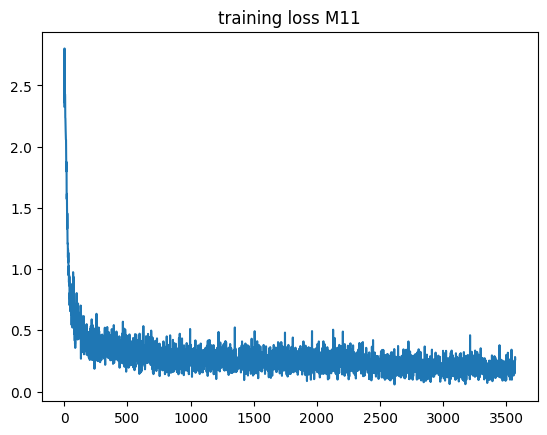

In [23]:
plt.plot(losses);
plt.title("training loss M11");

In [91]:
torch.save(model_m11.state_dict(), 'm11.model')

Обучим m18

In [71]:
optimizer = optim.Adam(model_m18.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

losses = []
accuracy_test = []
losses_test = []
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_m18, optimizer, epoch, log_interval)
        test(model_m18, epoch)
        scheduler.step()

  0%|          | 0.013422818791946308/30 [00:00<18:00, 36.04s/it]

Train Epoch: 1 [0/30441 (0%)]	Loss: 2.330025	Accuracy: 29/30441 (0%)


  0%|          | 0.14765100671140938/30 [00:05<17:34, 35.31s/it]

Train Epoch: 1 [5120/30441 (17%)]	Loss: 2.311452	Accuracy: 636/30441 (2%)


  1%|          | 0.2818791946308723/30 [00:09<15:39, 31.60s/it] 

Train Epoch: 1 [10240/30441 (34%)]	Loss: 1.943217	Accuracy: 1564/30441 (5%)


  1%|▏         | 0.4161073825503352/30 [00:14<16:23, 33.24s/it] 

Train Epoch: 1 [15360/30441 (50%)]	Loss: 1.572091	Accuracy: 3474/30441 (11%)


  2%|▏         | 0.5503355704697981/30 [00:18<16:15, 33.12s/it]

Train Epoch: 1 [20480/30441 (67%)]	Loss: 1.096619	Accuracy: 5921/30441 (19%)


  2%|▏         | 0.684563758389261/30 [00:23<15:33, 31.86s/it] 

Train Epoch: 1 [25600/30441 (84%)]	Loss: 0.915510	Accuracy: 8906/30441 (29%)


  3%|▎         | 0.9999999999999988/30 [00:31<08:33, 17.70s/it]


Test Epoch: 1 	Loss: 17.477282	Accuracy: 759/7611 (10%)



  3%|▎         | 1.0134228187919452/30 [00:31<10:18, 21.34s/it]

Train Epoch: 2 [0/30441 (0%)]	Loss: 0.689735	Accuracy: 205/30441 (1%)


  4%|▍         | 1.1476510067114103/30 [00:35<15:30, 32.24s/it]

Train Epoch: 2 [5120/30441 (17%)]	Loss: 0.691998	Accuracy: 3862/30441 (13%)


  4%|▍         | 1.2818791946308754/30 [00:40<15:51, 33.13s/it]

Train Epoch: 2 [10240/30441 (34%)]	Loss: 0.715286	Accuracy: 7674/30441 (25%)


  5%|▍         | 1.4161073825503405/30 [00:45<15:16, 32.08s/it]

Train Epoch: 2 [15360/30441 (50%)]	Loss: 0.660627	Accuracy: 11484/30441 (38%)


  5%|▌         | 1.5503355704698056/30 [00:49<15:47, 33.29s/it]

Train Epoch: 2 [20480/30441 (67%)]	Loss: 0.568327	Accuracy: 15607/30441 (51%)


  6%|▌         | 1.6845637583892707/30 [00:54<16:29, 34.94s/it]

Train Epoch: 2 [25600/30441 (84%)]	Loss: 0.591946	Accuracy: 19831/30441 (65%)


  7%|▋         | 2.0000000000000138/30 [01:01<08:00, 17.16s/it]


Test Epoch: 2 	Loss: 8.278576	Accuracy: 1666/7611 (22%)



  7%|▋         | 2.0134228187919603/30 [01:02<10:24, 22.33s/it]

Train Epoch: 3 [0/30441 (0%)]	Loss: 0.495957	Accuracy: 217/30441 (1%)


  7%|▋         | 2.1476510067114254/30 [01:06<16:16, 35.05s/it]

Train Epoch: 3 [5120/30441 (17%)]	Loss: 0.472851	Accuracy: 4594/30441 (15%)


  8%|▊         | 2.2818791946308905/30 [01:11<14:53, 32.22s/it]

Train Epoch: 3 [10240/30441 (34%)]	Loss: 0.520939	Accuracy: 9013/30441 (30%)


  8%|▊         | 2.4161073825503556/30 [01:15<14:27, 31.44s/it]

Train Epoch: 3 [15360/30441 (50%)]	Loss: 0.482651	Accuracy: 13588/30441 (45%)


  9%|▊         | 2.5503355704698207/30 [01:20<14:51, 32.49s/it]

Train Epoch: 3 [20480/30441 (67%)]	Loss: 0.458309	Accuracy: 18125/30441 (60%)


  9%|▉         | 2.684563758389286/30 [01:24<14:15, 31.33s/it] 

Train Epoch: 3 [25600/30441 (84%)]	Loss: 0.392864	Accuracy: 22721/30441 (75%)


 10%|█         | 3.000000000000029/30 [01:32<07:50, 17.42s/it] 


Test Epoch: 3 	Loss: 8.501143	Accuracy: 789/7611 (10%)



 10%|█         | 3.0134228187919754/30 [01:33<09:41, 21.54s/it]

Train Epoch: 4 [0/30441 (0%)]	Loss: 0.446890	Accuracy: 228/30441 (1%)


 10%|█         | 3.1476510067114405/30 [01:37<14:42, 32.86s/it]

Train Epoch: 4 [5120/30441 (17%)]	Loss: 0.370681	Accuracy: 4805/30441 (16%)


 11%|█         | 3.2818791946309056/30 [01:42<15:39, 35.18s/it]

Train Epoch: 4 [10240/30441 (34%)]	Loss: 0.450257	Accuracy: 9438/30441 (31%)


 11%|█▏        | 3.4161073825503707/30 [01:46<14:14, 32.13s/it]

Train Epoch: 4 [15360/30441 (50%)]	Loss: 0.372073	Accuracy: 14066/30441 (46%)


 12%|█▏        | 3.550335570469836/30 [01:51<14:13, 32.26s/it] 

Train Epoch: 4 [20480/30441 (67%)]	Loss: 0.394981	Accuracy: 18740/30441 (62%)


 12%|█▏        | 3.684563758389301/30 [01:56<15:09, 34.56s/it] 

Train Epoch: 4 [25600/30441 (84%)]	Loss: 0.492436	Accuracy: 23377/30441 (77%)


 13%|█▎        | 4.0000000000000435/30 [02:03<07:38, 17.63s/it]


Test Epoch: 4 	Loss: 2.838218	Accuracy: 2793/7611 (37%)



 13%|█▎        | 4.01342281879199/30 [02:03<09:24, 21.71s/it] 

Train Epoch: 5 [0/30441 (0%)]	Loss: 0.344012	Accuracy: 237/30441 (1%)


 14%|█▍        | 4.147651006711455/30 [02:08<14:55, 34.62s/it]

Train Epoch: 5 [5120/30441 (17%)]	Loss: 0.234521	Accuracy: 4918/30441 (16%)


 14%|█▍        | 4.28187919463092/30 [02:13<13:53, 32.43s/it] 

Train Epoch: 5 [10240/30441 (34%)]	Loss: 0.337848	Accuracy: 9595/30441 (32%)


 15%|█▍        | 4.416107382550385/30 [02:17<13:26, 31.53s/it]

Train Epoch: 5 [15360/30441 (50%)]	Loss: 0.293916	Accuracy: 14272/30441 (47%)


 15%|█▌        | 4.5503355704698505/30 [02:22<14:01, 33.05s/it]

Train Epoch: 5 [20480/30441 (67%)]	Loss: 0.279139	Accuracy: 19034/30441 (63%)


 16%|█▌        | 4.684563758389316/30 [02:26<13:38, 32.34s/it]

Train Epoch: 5 [25600/30441 (84%)]	Loss: 0.261317	Accuracy: 23785/30441 (78%)


 17%|█▋        | 4.993288590604085/30 [02:34<07:20, 17.63s/it]


Test Epoch: 5 	Loss: 6.211524	Accuracy: 1622/7611 (21%)



 17%|█▋        | 5.013422818792005/30 [02:35<08:31, 20.45s/it]

Train Epoch: 6 [0/30441 (0%)]	Loss: 0.342676	Accuracy: 240/30441 (1%)


 17%|█▋        | 5.14765100671147/30 [02:39<13:45, 33.24s/it] 

Train Epoch: 6 [5120/30441 (17%)]	Loss: 0.232321	Accuracy: 4988/30441 (16%)


 18%|█▊        | 5.281879194630935/30 [02:44<14:25, 35.03s/it]

Train Epoch: 6 [10240/30441 (34%)]	Loss: 0.435340	Accuracy: 9782/30441 (32%)


 18%|█▊        | 5.4161073825504005/30 [02:48<13:21, 32.62s/it]

Train Epoch: 6 [15360/30441 (50%)]	Loss: 0.267767	Accuracy: 14512/30441 (48%)


 19%|█▊        | 5.550335570469866/30 [02:53<13:40, 33.57s/it]

Train Epoch: 6 [20480/30441 (67%)]	Loss: 0.309963	Accuracy: 19279/30441 (63%)


 19%|█▉        | 5.684563758389331/30 [02:58<13:40, 33.72s/it] 

Train Epoch: 6 [25600/30441 (84%)]	Loss: 0.408531	Accuracy: 24024/30441 (79%)


 20%|██        | 6.000000000000074/30 [03:05<07:01, 17.57s/it] 


Test Epoch: 6 	Loss: 2.932017	Accuracy: 1535/7611 (20%)



 20%|██        | 6.01342281879202/30 [03:06<09:14, 23.10s/it] 

Train Epoch: 7 [0/30441 (0%)]	Loss: 0.337776	Accuracy: 237/30441 (1%)


 20%|██        | 6.147651006711485/30 [03:10<13:09, 33.09s/it]

Train Epoch: 7 [5120/30441 (17%)]	Loss: 0.371288	Accuracy: 5020/30441 (16%)


 21%|██        | 6.2818791946309505/30 [03:15<13:15, 33.52s/it]

Train Epoch: 7 [10240/30441 (34%)]	Loss: 0.215932	Accuracy: 9831/30441 (32%)


 21%|██▏       | 6.416107382550416/30 [03:20<12:56, 32.92s/it]

Train Epoch: 7 [15360/30441 (50%)]	Loss: 0.286748	Accuracy: 14616/30441 (48%)


 22%|██▏       | 6.550335570469881/30 [03:24<13:10, 33.69s/it]

Train Epoch: 7 [20480/30441 (67%)]	Loss: 0.302252	Accuracy: 19436/30441 (64%)


 22%|██▏       | 6.684563758389346/30 [03:29<12:58, 33.37s/it] 

Train Epoch: 7 [25600/30441 (84%)]	Loss: 0.237280	Accuracy: 24251/30441 (80%)


 23%|██▎       | 7.000000000000089/30 [03:37<06:51, 17.87s/it]


Test Epoch: 7 	Loss: 4.089415	Accuracy: 1359/7611 (18%)



 23%|██▎       | 7.013422818792035/30 [03:37<08:40, 22.62s/it]

Train Epoch: 8 [0/30441 (0%)]	Loss: 0.355228	Accuracy: 241/30441 (1%)


 24%|██▍       | 7.1476510067115/30 [03:42<12:17, 32.26s/it]  

Train Epoch: 8 [5120/30441 (17%)]	Loss: 0.314272	Accuracy: 5052/30441 (17%)


 24%|██▍       | 7.281879194630966/30 [03:46<13:14, 34.99s/it]

Train Epoch: 8 [10240/30441 (34%)]	Loss: 0.371467	Accuracy: 9845/30441 (32%)


 25%|██▍       | 7.416107382550431/30 [03:51<12:43, 33.80s/it]

Train Epoch: 8 [15360/30441 (50%)]	Loss: 0.330003	Accuracy: 14642/30441 (48%)


 25%|██▌       | 7.550335570469896/30 [03:55<11:56, 31.90s/it] 

Train Epoch: 8 [20480/30441 (67%)]	Loss: 0.372980	Accuracy: 19476/30441 (64%)


 26%|██▌       | 7.684563758389361/30 [04:00<12:25, 33.40s/it]

Train Epoch: 8 [25600/30441 (84%)]	Loss: 0.230735	Accuracy: 24259/30441 (80%)


 27%|██▋       | 8.000000000000103/30 [04:08<06:22, 17.39s/it]


Test Epoch: 8 	Loss: 6.187298	Accuracy: 1788/7611 (23%)



 27%|██▋       | 8.013422818792048/30 [04:08<08:10, 22.29s/it]

Train Epoch: 9 [0/30441 (0%)]	Loss: 0.172349	Accuracy: 249/30441 (1%)


 27%|██▋       | 8.147651006711495/30 [04:13<11:43, 32.21s/it]

Train Epoch: 9 [5120/30441 (17%)]	Loss: 0.279375	Accuracy: 5024/30441 (17%)


 28%|██▊       | 8.281879194630942/30 [04:17<12:19, 34.06s/it]

Train Epoch: 9 [10240/30441 (34%)]	Loss: 0.199195	Accuracy: 9858/30441 (32%)


 28%|██▊       | 8.41610738255039/30 [04:22<12:52, 35.79s/it] 

Train Epoch: 9 [15360/30441 (50%)]	Loss: 0.284957	Accuracy: 14626/30441 (48%)


 29%|██▊       | 8.550335570469837/30 [04:27<11:45, 32.90s/it]

Train Epoch: 9 [20480/30441 (67%)]	Loss: 0.282877	Accuracy: 19459/30441 (64%)


 29%|██▉       | 8.684563758389285/30 [04:31<11:25, 32.15s/it]

Train Epoch: 9 [25600/30441 (84%)]	Loss: 0.226828	Accuracy: 24300/30441 (80%)


 30%|██▉       | 8.999999999999986/30 [04:39<06:08, 17.53s/it]


Test Epoch: 9 	Loss: 4.520289	Accuracy: 1346/7611 (18%)



 30%|███       | 9.01342281879193/30 [04:40<07:59, 22.86s/it] 

Train Epoch: 10 [0/30441 (0%)]	Loss: 0.301094	Accuracy: 241/30441 (1%)


 30%|███       | 9.147651006711378/30 [04:44<11:24, 32.82s/it]

Train Epoch: 10 [5120/30441 (17%)]	Loss: 0.387798	Accuracy: 5052/30441 (17%)


 31%|███       | 9.281879194630825/30 [04:49<11:55, 34.52s/it]

Train Epoch: 10 [10240/30441 (34%)]	Loss: 0.298929	Accuracy: 9886/30441 (32%)


 31%|███▏      | 9.416107382550273/30 [04:53<11:43, 34.17s/it]

Train Epoch: 10 [15360/30441 (50%)]	Loss: 0.375731	Accuracy: 14727/30441 (48%)


 32%|███▏      | 9.55033557046972/30 [04:58<11:29, 33.73s/it] 

Train Epoch: 10 [20480/30441 (67%)]	Loss: 0.363860	Accuracy: 19575/30441 (64%)


 32%|███▏      | 9.684563758389167/30 [05:03<10:48, 31.90s/it]

Train Epoch: 10 [25600/30441 (84%)]	Loss: 0.395926	Accuracy: 24443/30441 (80%)


 33%|███▎      | 9.993288590603896/30 [05:10<06:00, 18.02s/it]


Test Epoch: 10 	Loss: 3.873517	Accuracy: 1834/7611 (24%)



 33%|███▎      | 10.013422818791813/30 [05:11<07:28, 22.46s/it]

Train Epoch: 11 [0/30441 (0%)]	Loss: 0.247401	Accuracy: 246/30441 (1%)


 34%|███▍      | 10.14765100671126/30 [05:15<10:53, 32.94s/it] 

Train Epoch: 11 [5120/30441 (17%)]	Loss: 0.398290	Accuracy: 5097/30441 (17%)


 34%|███▍      | 10.281879194630708/30 [05:20<10:53, 33.13s/it]

Train Epoch: 11 [10240/30441 (34%)]	Loss: 0.236497	Accuracy: 9964/30441 (33%)


 35%|███▍      | 10.416107382550155/30 [05:25<11:50, 36.29s/it]

Train Epoch: 11 [15360/30441 (50%)]	Loss: 0.247022	Accuracy: 14820/30441 (49%)


 35%|███▌      | 10.550335570469603/30 [05:29<10:24, 32.12s/it]

Train Epoch: 11 [20480/30441 (67%)]	Loss: 0.287098	Accuracy: 19678/30441 (65%)


 36%|███▌      | 10.68456375838905/30 [05:34<10:27, 32.49s/it] 

Train Epoch: 11 [25600/30441 (84%)]	Loss: 0.278128	Accuracy: 24514/30441 (81%)


 37%|███▋      | 10.999999999999751/30 [05:41<05:31, 17.43s/it]


Test Epoch: 11 	Loss: 2.544770	Accuracy: 2966/7611 (39%)



 37%|███▋      | 11.013422818791696/30 [05:42<06:45, 21.35s/it]

Train Epoch: 12 [0/30441 (0%)]	Loss: 0.398623	Accuracy: 240/30441 (1%)


 37%|███▋      | 11.147651006711143/30 [05:46<10:20, 32.94s/it]

Train Epoch: 12 [5120/30441 (17%)]	Loss: 0.299200	Accuracy: 5080/30441 (17%)


 38%|███▊      | 11.28187919463059/30 [05:51<10:08, 32.49s/it] 

Train Epoch: 12 [10240/30441 (34%)]	Loss: 0.229815	Accuracy: 9925/30441 (33%)


 38%|███▊      | 11.416107382550038/30 [05:56<10:30, 33.92s/it]

Train Epoch: 12 [15360/30441 (50%)]	Loss: 0.277679	Accuracy: 14772/30441 (49%)


 39%|███▊      | 11.550335570469485/30 [06:00<10:24, 33.86s/it]

Train Epoch: 12 [20480/30441 (67%)]	Loss: 0.238671	Accuracy: 19606/30441 (64%)


 39%|███▉      | 11.684563758388933/30 [06:05<09:55, 32.51s/it]

Train Epoch: 12 [25600/30441 (84%)]	Loss: 0.216720	Accuracy: 24447/30441 (80%)


 40%|███▉      | 11.999999999999634/30 [06:12<05:48, 19.37s/it]


Test Epoch: 12 	Loss: 4.296317	Accuracy: 1239/7611 (16%)



 40%|████      | 12.013422818791579/30 [06:13<07:21, 24.52s/it]

Train Epoch: 13 [0/30441 (0%)]	Loss: 0.430038	Accuracy: 240/30441 (1%)


 40%|████      | 12.147651006711026/30 [06:17<09:43, 32.70s/it]

Train Epoch: 13 [5120/30441 (17%)]	Loss: 0.352597	Accuracy: 5107/30441 (17%)


 41%|████      | 12.281879194630474/30 [06:22<09:32, 32.32s/it]

Train Epoch: 13 [10240/30441 (34%)]	Loss: 0.311787	Accuracy: 9972/30441 (33%)


 41%|████▏     | 12.41610738254992/30 [06:27<09:56, 33.92s/it] 

Train Epoch: 13 [15360/30441 (50%)]	Loss: 0.214721	Accuracy: 14871/30441 (49%)


 42%|████▏     | 12.550335570469368/30 [06:31<09:52, 33.98s/it]

Train Epoch: 13 [20480/30441 (67%)]	Loss: 0.239872	Accuracy: 19755/30441 (65%)


 42%|████▏     | 12.684563758388816/30 [06:36<09:39, 33.45s/it]

Train Epoch: 13 [25600/30441 (84%)]	Loss: 0.201416	Accuracy: 24608/30441 (81%)


 43%|████▎     | 12.999999999999517/30 [06:44<04:57, 17.48s/it]


Test Epoch: 13 	Loss: 3.522179	Accuracy: 1731/7611 (23%)



 43%|████▎     | 13.013422818791462/30 [06:44<06:16, 22.16s/it]

Train Epoch: 14 [0/30441 (0%)]	Loss: 0.300473	Accuracy: 239/30441 (1%)


 44%|████▍     | 13.147651006710909/30 [06:48<09:14, 32.90s/it]

Train Epoch: 14 [5120/30441 (17%)]	Loss: 0.321538	Accuracy: 5078/30441 (17%)


 44%|████▍     | 13.281879194630356/30 [06:53<09:16, 33.28s/it]

Train Epoch: 14 [10240/30441 (34%)]	Loss: 0.380973	Accuracy: 9930/30441 (33%)


 45%|████▍     | 13.416107382549804/30 [06:58<09:04, 32.86s/it]

Train Epoch: 14 [15360/30441 (50%)]	Loss: 0.218811	Accuracy: 14770/30441 (49%)


 45%|████▌     | 13.550335570469251/30 [07:02<09:44, 35.53s/it]

Train Epoch: 14 [20480/30441 (67%)]	Loss: 0.358172	Accuracy: 19596/30441 (64%)


 46%|████▌     | 13.684563758388698/30 [07:07<08:45, 32.23s/it]

Train Epoch: 14 [25600/30441 (84%)]	Loss: 0.258583	Accuracy: 24444/30441 (80%)


 47%|████▋     | 13.9999999999994/30 [07:15<05:17, 19.83s/it]  


Test Epoch: 14 	Loss: 6.980026	Accuracy: 789/7611 (10%)



 47%|████▋     | 14.013422818791344/30 [07:15<06:30, 24.44s/it]

Train Epoch: 15 [0/30441 (0%)]	Loss: 0.425630	Accuracy: 235/30441 (1%)


 47%|████▋     | 14.147651006710792/30 [07:20<08:43, 33.02s/it]

Train Epoch: 15 [5120/30441 (17%)]	Loss: 0.308036	Accuracy: 5105/30441 (17%)


 48%|████▊     | 14.281879194630239/30 [07:24<08:23, 32.03s/it]

Train Epoch: 15 [10240/30441 (34%)]	Loss: 0.241394	Accuracy: 10000/30441 (33%)


 48%|████▊     | 14.416107382549686/30 [07:29<08:16, 31.89s/it]

Train Epoch: 15 [15360/30441 (50%)]	Loss: 0.227648	Accuracy: 14873/30441 (49%)


 49%|████▊     | 14.550335570469134/30 [07:33<08:25, 32.74s/it]

Train Epoch: 15 [20480/30441 (67%)]	Loss: 0.353855	Accuracy: 19723/30441 (65%)


 49%|████▉     | 14.684563758388581/30 [07:38<08:34, 33.61s/it]

Train Epoch: 15 [25600/30441 (84%)]	Loss: 0.283672	Accuracy: 24612/30441 (81%)


 50%|████▉     | 14.99328859060331/30 [07:45<04:32, 18.16s/it] 


Test Epoch: 15 	Loss: 2.387779	Accuracy: 2032/7611 (27%)



 50%|█████     | 15.013422818791227/30 [07:46<05:16, 21.13s/it]

Train Epoch: 16 [0/30441 (0%)]	Loss: 0.349463	Accuracy: 242/30441 (1%)


 50%|█████     | 15.147651006710674/30 [07:51<08:37, 34.87s/it]

Train Epoch: 16 [5120/30441 (17%)]	Loss: 0.289827	Accuracy: 5119/30441 (17%)


 51%|█████     | 15.281879194630122/30 [07:55<07:58, 32.53s/it]

Train Epoch: 16 [10240/30441 (34%)]	Loss: 0.205711	Accuracy: 9985/30441 (33%)


 51%|█████▏    | 15.41610738254957/30 [08:00<08:09, 33.53s/it] 

Train Epoch: 16 [15360/30441 (50%)]	Loss: 0.213965	Accuracy: 14863/30441 (49%)


 52%|█████▏    | 15.550335570469016/30 [08:05<08:33, 35.55s/it]

Train Epoch: 16 [20480/30441 (67%)]	Loss: 0.334319	Accuracy: 19727/30441 (65%)


 52%|█████▏    | 15.684563758388464/30 [08:09<07:45, 32.50s/it]

Train Epoch: 16 [25600/30441 (84%)]	Loss: 0.252334	Accuracy: 24591/30441 (81%)


 53%|█████▎    | 15.999999999999165/30 [08:17<04:10, 17.91s/it]


Test Epoch: 16 	Loss: 5.114036	Accuracy: 1133/7611 (15%)



 53%|█████▎    | 16.01342281879111/30 [08:17<05:04, 21.78s/it] 

Train Epoch: 17 [0/30441 (0%)]	Loss: 0.224312	Accuracy: 247/30441 (1%)


 54%|█████▍    | 16.147651006710557/30 [08:22<07:45, 33.61s/it]

Train Epoch: 17 [5120/30441 (17%)]	Loss: 0.244024	Accuracy: 5096/30441 (17%)


 54%|█████▍    | 16.281879194630005/30 [08:26<07:39, 33.51s/it]

Train Epoch: 17 [10240/30441 (34%)]	Loss: 0.289888	Accuracy: 9973/30441 (33%)


 55%|█████▍    | 16.416107382549452/30 [08:31<07:23, 32.64s/it]

Train Epoch: 17 [15360/30441 (50%)]	Loss: 0.254632	Accuracy: 14840/30441 (49%)


 55%|█████▌    | 16.5503355704689/30 [08:36<07:20, 32.73s/it]  

Train Epoch: 17 [20480/30441 (67%)]	Loss: 0.352596	Accuracy: 19721/30441 (65%)


 56%|█████▌    | 16.684563758388347/30 [08:40<07:47, 35.14s/it]

Train Epoch: 17 [25600/30441 (84%)]	Loss: 0.235526	Accuracy: 24587/30441 (81%)


 57%|█████▋    | 16.999999999999048/30 [08:48<03:50, 17.71s/it]


Test Epoch: 17 	Loss: 13.588631	Accuracy: 761/7611 (10%)



 57%|█████▋    | 17.013422818790993/30 [08:48<04:52, 22.51s/it]

Train Epoch: 18 [0/30441 (0%)]	Loss: 0.308525	Accuracy: 245/30441 (1%)


 57%|█████▋    | 17.14765100671044/30 [08:53<07:43, 36.08s/it] 

Train Epoch: 18 [5120/30441 (17%)]	Loss: 0.178739	Accuracy: 5105/30441 (17%)


 58%|█████▊    | 17.281879194629887/30 [08:58<07:11, 33.94s/it]

Train Epoch: 18 [10240/30441 (34%)]	Loss: 0.229909	Accuracy: 10023/30441 (33%)


 58%|█████▊    | 17.416107382549335/30 [09:02<06:49, 32.55s/it]

Train Epoch: 18 [15360/30441 (50%)]	Loss: 0.306944	Accuracy: 14915/30441 (49%)


 59%|█████▊    | 17.550335570468782/30 [09:07<06:48, 32.84s/it]

Train Epoch: 18 [20480/30441 (67%)]	Loss: 0.310347	Accuracy: 19790/30441 (65%)


 59%|█████▉    | 17.68456375838823/30 [09:12<06:50, 33.30s/it] 

Train Epoch: 18 [25600/30441 (84%)]	Loss: 0.255684	Accuracy: 24655/30441 (81%)


 60%|█████▉    | 17.99999999999893/30 [09:20<03:29, 17.45s/it]


Test Epoch: 18 	Loss: 5.475697	Accuracy: 820/7611 (11%)



 60%|██████    | 18.013422818790875/30 [09:20<04:21, 21.80s/it]

Train Epoch: 19 [0/30441 (0%)]	Loss: 0.238342	Accuracy: 244/30441 (1%)


 60%|██████    | 18.147651006710323/30 [09:25<06:26, 32.63s/it]

Train Epoch: 19 [5120/30441 (17%)]	Loss: 0.327336	Accuracy: 5120/30441 (17%)


 61%|██████    | 18.28187919462977/30 [09:29<07:01, 35.99s/it] 

Train Epoch: 19 [10240/30441 (34%)]	Loss: 0.259172	Accuracy: 9994/30441 (33%)


 61%|██████▏   | 18.416107382549217/30 [09:34<06:12, 32.16s/it]

Train Epoch: 19 [15360/30441 (50%)]	Loss: 0.255781	Accuracy: 14888/30441 (49%)


 62%|██████▏   | 18.550335570468665/30 [09:38<06:10, 32.37s/it]

Train Epoch: 19 [20480/30441 (67%)]	Loss: 0.206175	Accuracy: 19783/30441 (65%)


 62%|██████▏   | 18.684563758388112/30 [09:43<06:19, 33.53s/it]

Train Epoch: 19 [25600/30441 (84%)]	Loss: 0.230229	Accuracy: 24664/30441 (81%)


 63%|██████▎   | 18.999999999998813/30 [09:51<03:07, 17.02s/it]


Test Epoch: 19 	Loss: 2.065192	Accuracy: 3147/7611 (41%)



 63%|██████▎   | 19.013422818790758/30 [09:51<04:02, 22.04s/it]

Train Epoch: 20 [0/30441 (0%)]	Loss: 0.160909	Accuracy: 248/30441 (1%)


 64%|██████▍   | 19.147651006710205/30 [09:56<06:04, 33.63s/it]

Train Epoch: 20 [5120/30441 (17%)]	Loss: 0.367624	Accuracy: 5129/30441 (17%)


 64%|██████▍   | 19.281879194629653/30 [10:00<05:47, 32.38s/it]

Train Epoch: 20 [10240/30441 (34%)]	Loss: 0.205372	Accuracy: 10002/30441 (33%)


 65%|██████▍   | 19.4161073825491/30 [10:05<06:13, 35.30s/it]  

Train Epoch: 20 [15360/30441 (50%)]	Loss: 0.212465	Accuracy: 14880/30441 (49%)


 65%|██████▌   | 19.550335570468548/30 [10:10<05:44, 32.96s/it]

Train Epoch: 20 [20480/30441 (67%)]	Loss: 0.236692	Accuracy: 19790/30441 (65%)


 66%|██████▌   | 19.684563758387995/30 [10:14<05:37, 32.74s/it]

Train Epoch: 20 [25600/30441 (84%)]	Loss: 0.256486	Accuracy: 24687/30441 (81%)


 67%|██████▋   | 19.999999999998696/30 [10:22<02:52, 17.23s/it]


Test Epoch: 20 	Loss: 2.838824	Accuracy: 1910/7611 (25%)



 67%|██████▋   | 20.01342281879064/30 [10:22<03:36, 21.66s/it]

Train Epoch: 21 [0/30441 (0%)]	Loss: 0.194910	Accuracy: 250/30441 (1%)


 67%|██████▋   | 20.14765100671009/30 [10:27<05:31, 33.65s/it] 

Train Epoch: 21 [5120/30441 (17%)]	Loss: 0.278612	Accuracy: 5159/30441 (17%)


 68%|██████▊   | 20.281879194629536/30 [10:31<05:26, 33.57s/it]

Train Epoch: 21 [10240/30441 (34%)]	Loss: 0.183100	Accuracy: 10096/30441 (33%)


 68%|██████▊   | 20.416107382548983/30 [10:36<05:15, 32.93s/it]

Train Epoch: 21 [15360/30441 (50%)]	Loss: 0.209689	Accuracy: 15044/30441 (49%)


 69%|██████▊   | 20.55033557046843/30 [10:41<05:06, 32.43s/it] 

Train Epoch: 21 [20480/30441 (67%)]	Loss: 0.149895	Accuracy: 19974/30441 (66%)


 69%|██████▉   | 20.684563758387878/30 [10:45<05:14, 33.74s/it]

Train Epoch: 21 [25600/30441 (84%)]	Loss: 0.165417	Accuracy: 24903/30441 (82%)


 70%|███████   | 21.00671140939455/30 [10:53<03:13, 21.53s/it]


Test Epoch: 21 	Loss: 1.738915	Accuracy: 3595/7611 (47%)

Train Epoch: 22 [0/30441 (0%)]	Loss: 0.185066	Accuracy: 247/30441 (1%)


 70%|███████   | 21.14765100670997/30 [10:58<04:57, 33.63s/it]

Train Epoch: 22 [5120/30441 (17%)]	Loss: 0.226365	Accuracy: 5180/30441 (17%)


 71%|███████   | 21.28187919462942/30 [11:03<04:47, 33.00s/it] 

Train Epoch: 22 [10240/30441 (34%)]	Loss: 0.239267	Accuracy: 10127/30441 (33%)


 71%|███████▏  | 21.416107382548866/30 [11:07<05:10, 36.22s/it]

Train Epoch: 22 [15360/30441 (50%)]	Loss: 0.268178	Accuracy: 15051/30441 (49%)


 72%|███████▏  | 21.550335570468313/30 [11:12<04:29, 31.87s/it]

Train Epoch: 22 [20480/30441 (67%)]	Loss: 0.168054	Accuracy: 20017/30441 (66%)


 72%|███████▏  | 21.68456375838776/30 [11:16<04:41, 33.82s/it] 

Train Epoch: 22 [25600/30441 (84%)]	Loss: 0.158994	Accuracy: 24955/30441 (82%)


 73%|███████▎  | 21.99999999999846/30 [11:24<02:19, 17.41s/it]


Test Epoch: 22 	Loss: 0.943391	Accuracy: 5138/7611 (68%)



 73%|███████▎  | 22.013422818790406/30 [11:24<02:59, 22.52s/it]

Train Epoch: 23 [0/30441 (0%)]	Loss: 0.234260	Accuracy: 246/30441 (1%)


 74%|███████▍  | 22.147651006709854/30 [11:29<04:16, 32.60s/it]

Train Epoch: 23 [5120/30441 (17%)]	Loss: 0.156717	Accuracy: 5206/30441 (17%)


 74%|███████▍  | 22.2818791946293/30 [11:34<04:09, 32.29s/it] 

Train Epoch: 23 [10240/30441 (34%)]	Loss: 0.226045	Accuracy: 10151/30441 (33%)


 75%|███████▍  | 22.41610738254875/30 [11:38<04:08, 32.81s/it] 

Train Epoch: 23 [15360/30441 (50%)]	Loss: 0.237892	Accuracy: 15111/30441 (50%)


 75%|███████▌  | 22.550335570468196/30 [11:43<04:20, 35.01s/it]

Train Epoch: 23 [20480/30441 (67%)]	Loss: 0.387635	Accuracy: 20035/30441 (66%)


 76%|███████▌  | 22.684563758387643/30 [11:48<03:55, 32.23s/it]

Train Epoch: 23 [25600/30441 (84%)]	Loss: 0.160454	Accuracy: 24976/30441 (82%)


 77%|███████▋  | 22.999999999998344/30 [11:55<02:17, 19.71s/it]


Test Epoch: 23 	Loss: 0.812441	Accuracy: 5402/7611 (71%)



 77%|███████▋  | 23.01342281879029/30 [11:56<02:53, 24.79s/it] 

Train Epoch: 24 [0/30441 (0%)]	Loss: 0.167793	Accuracy: 249/30441 (1%)


 77%|███████▋  | 23.147651006709737/30 [12:00<03:45, 32.91s/it]

Train Epoch: 24 [5120/30441 (17%)]	Loss: 0.168680	Accuracy: 5210/30441 (17%)


 78%|███████▊  | 23.281879194629184/30 [12:05<03:42, 33.18s/it]

Train Epoch: 24 [10240/30441 (34%)]	Loss: 0.171229	Accuracy: 10128/30441 (33%)


 78%|███████▊  | 23.41610738254863/30 [12:10<03:49, 34.93s/it]

Train Epoch: 24 [15360/30441 (50%)]	Loss: 0.281472	Accuracy: 15081/30441 (50%)


 79%|███████▊  | 23.55033557046808/30 [12:14<03:26, 31.96s/it] 

Train Epoch: 24 [20480/30441 (67%)]	Loss: 0.267255	Accuracy: 20015/30441 (66%)


 79%|███████▉  | 23.684563758387526/30 [12:19<03:27, 32.88s/it]

Train Epoch: 24 [25600/30441 (84%)]	Loss: 0.135360	Accuracy: 24971/30441 (82%)


 80%|███████▉  | 23.999999999998227/30 [12:26<01:43, 17.22s/it]


Test Epoch: 24 	Loss: 1.293167	Accuracy: 4284/7611 (56%)



 80%|████████  | 24.013422818790172/30 [12:27<02:10, 21.72s/it]

Train Epoch: 25 [0/30441 (0%)]	Loss: 0.252726	Accuracy: 247/30441 (1%)


 80%|████████  | 24.14765100670962/30 [12:31<03:17, 33.68s/it] 

Train Epoch: 25 [5120/30441 (17%)]	Loss: 0.230092	Accuracy: 5191/30441 (17%)


 81%|████████  | 24.281879194629067/30 [12:36<03:05, 32.41s/it]

Train Epoch: 25 [10240/30441 (34%)]	Loss: 0.139584	Accuracy: 10145/30441 (33%)


 81%|████████▏ | 24.416107382548514/30 [12:41<03:01, 32.43s/it]

Train Epoch: 25 [15360/30441 (50%)]	Loss: 0.244126	Accuracy: 15090/30441 (50%)


 82%|████████▏ | 24.55033557046796/30 [12:45<03:18, 36.37s/it]

Train Epoch: 25 [20480/30441 (67%)]	Loss: 0.317736	Accuracy: 20032/30441 (66%)


 82%|████████▏ | 24.68456375838741/30 [12:50<02:58, 33.50s/it] 

Train Epoch: 25 [25600/30441 (84%)]	Loss: 0.244979	Accuracy: 24970/30441 (82%)


 83%|████████▎ | 24.99999999999811/30 [12:58<01:38, 19.79s/it] 


Test Epoch: 25 	Loss: 2.150555	Accuracy: 2871/7611 (38%)



 83%|████████▎ | 25.013422818790055/30 [12:58<01:55, 23.16s/it]

Train Epoch: 26 [0/30441 (0%)]	Loss: 0.241369	Accuracy: 247/30441 (1%)


 84%|████████▍ | 25.147651006709502/30 [13:03<02:43, 33.62s/it]

Train Epoch: 26 [5120/30441 (17%)]	Loss: 0.214487	Accuracy: 5200/30441 (17%)


 84%|████████▍ | 25.28187919462895/30 [13:07<02:37, 33.36s/it] 

Train Epoch: 26 [10240/30441 (34%)]	Loss: 0.182279	Accuracy: 10150/30441 (33%)


 85%|████████▍ | 25.416107382548397/30 [13:12<02:30, 32.84s/it]

Train Epoch: 26 [15360/30441 (50%)]	Loss: 0.198265	Accuracy: 15086/30441 (50%)


 85%|████████▌ | 25.550335570467844/30 [13:16<02:28, 33.27s/it]

Train Epoch: 26 [20480/30441 (67%)]	Loss: 0.161791	Accuracy: 20028/30441 (66%)


 86%|████████▌ | 25.68456375838729/30 [13:21<02:29, 34.60s/it]

Train Epoch: 26 [25600/30441 (84%)]	Loss: 0.255144	Accuracy: 24984/30441 (82%)


 87%|████████▋ | 25.999999999997993/30 [13:29<01:10, 17.58s/it]


Test Epoch: 26 	Loss: 1.012753	Accuracy: 4897/7611 (64%)



 87%|████████▋ | 26.013422818789937/30 [13:29<01:26, 21.78s/it]

Train Epoch: 27 [0/30441 (0%)]	Loss: 0.145438	Accuracy: 251/30441 (1%)


 87%|████████▋ | 26.147651006709385/30 [13:34<02:22, 36.90s/it]

Train Epoch: 27 [5120/30441 (17%)]	Loss: 0.295181	Accuracy: 5177/30441 (17%)


 88%|████████▊ | 26.281879194628832/30 [13:38<02:04, 33.50s/it]

Train Epoch: 27 [10240/30441 (34%)]	Loss: 0.143663	Accuracy: 10135/30441 (33%)


 88%|████████▊ | 26.41610738254828/30 [13:43<01:57, 32.90s/it] 

Train Epoch: 27 [15360/30441 (50%)]	Loss: 0.137958	Accuracy: 15086/30441 (50%)


 89%|████████▊ | 26.550335570467727/30 [13:48<01:56, 33.85s/it]

Train Epoch: 27 [20480/30441 (67%)]	Loss: 0.082662	Accuracy: 20025/30441 (66%)


 89%|████████▉ | 26.684563758387174/30 [13:52<01:46, 32.20s/it]

Train Epoch: 27 [25600/30441 (84%)]	Loss: 0.144838	Accuracy: 24987/30441 (82%)


 90%|████████▉ | 26.999999999997875/30 [14:00<00:50, 16.97s/it]


Test Epoch: 27 	Loss: 0.584491	Accuracy: 6068/7611 (80%)



 90%|█████████ | 27.01342281878982/30 [14:01<01:06, 22.12s/it] 

Train Epoch: 28 [0/30441 (0%)]	Loss: 0.207407	Accuracy: 247/30441 (1%)


 90%|█████████ | 27.147651006709268/30 [14:05<01:35, 33.32s/it]

Train Epoch: 28 [5120/30441 (17%)]	Loss: 0.195412	Accuracy: 5191/30441 (17%)


 91%|█████████ | 27.281879194628715/30 [14:10<01:33, 34.57s/it]

Train Epoch: 28 [10240/30441 (34%)]	Loss: 0.336200	Accuracy: 10117/30441 (33%)


 91%|█████████▏| 27.416107382548162/30 [14:14<01:23, 32.38s/it]

Train Epoch: 28 [15360/30441 (50%)]	Loss: 0.325304	Accuracy: 15054/30441 (49%)


 92%|█████████▏| 27.55033557046761/30 [14:19<01:21, 33.40s/it] 

Train Epoch: 28 [20480/30441 (67%)]	Loss: 0.266969	Accuracy: 19988/30441 (66%)


 92%|█████████▏| 27.684563758387057/30 [14:24<01:20, 34.92s/it]

Train Epoch: 28 [25600/30441 (84%)]	Loss: 0.212783	Accuracy: 24952/30441 (82%)


 93%|█████████▎| 27.99999999999776/30 [14:31<00:34, 17.29s/it] 


Test Epoch: 28 	Loss: 1.043712	Accuracy: 4877/7611 (64%)



 93%|█████████▎| 28.013422818789703/30 [14:32<00:41, 21.13s/it]

Train Epoch: 29 [0/30441 (0%)]	Loss: 0.325837	Accuracy: 242/30441 (1%)


 94%|█████████▍| 28.14765100670915/30 [14:36<01:02, 33.87s/it] 

Train Epoch: 29 [5120/30441 (17%)]	Loss: 0.132204	Accuracy: 5201/30441 (17%)


 94%|█████████▍| 28.281879194628598/30 [14:41<00:56, 33.09s/it]

Train Epoch: 29 [10240/30441 (34%)]	Loss: 0.338287	Accuracy: 10156/30441 (33%)


 95%|█████████▍| 28.416107382548045/30 [14:46<00:49, 31.45s/it]

Train Epoch: 29 [15360/30441 (50%)]	Loss: 0.179077	Accuracy: 15116/30441 (50%)


 95%|█████████▌| 28.550335570467492/30 [14:50<00:48, 33.29s/it]

Train Epoch: 29 [20480/30441 (67%)]	Loss: 0.169788	Accuracy: 20043/30441 (66%)


 96%|█████████▌| 28.68456375838694/30 [14:55<00:43, 33.09s/it] 

Train Epoch: 29 [25600/30441 (84%)]	Loss: 0.183507	Accuracy: 24973/30441 (82%)


 97%|█████████▋| 28.99999999999764/30 [15:03<00:17, 17.06s/it]


Test Epoch: 29 	Loss: 0.829706	Accuracy: 5770/7611 (76%)



 97%|█████████▋| 29.013422818789586/30 [15:03<00:21, 21.35s/it]

Train Epoch: 30 [0/30441 (0%)]	Loss: 0.198567	Accuracy: 248/30441 (1%)


 97%|█████████▋| 29.147651006709033/30 [15:07<00:27, 32.47s/it]

Train Epoch: 30 [5120/30441 (17%)]	Loss: 0.151180	Accuracy: 5169/30441 (17%)


 98%|█████████▊| 29.28187919462848/30 [15:12<00:25, 35.27s/it] 

Train Epoch: 30 [10240/30441 (34%)]	Loss: 0.284014	Accuracy: 10131/30441 (33%)


 98%|█████████▊| 29.416107382547928/30 [15:17<00:19, 34.13s/it]

Train Epoch: 30 [15360/30441 (50%)]	Loss: 0.207973	Accuracy: 15096/30441 (50%)


 99%|█████████▊| 29.550335570467375/30 [15:21<00:14, 32.38s/it]

Train Epoch: 30 [20480/30441 (67%)]	Loss: 0.230326	Accuracy: 20039/30441 (66%)


 99%|█████████▉| 29.684563758386822/30 [15:26<00:10, 33.54s/it]

Train Epoch: 30 [25600/30441 (84%)]	Loss: 0.157987	Accuracy: 24981/30441 (82%)


100%|█████████▉| 29.999999999997524/30 [15:34<00:00, 31.14s/it]


Test Epoch: 30 	Loss: 1.291511	Accuracy: 4455/7611 (59%)



In [80]:
torch.save(model_m18.state_dict(), 'm18.model')

Вывод: из моделей m5, m11, m18 на 30 эпохах лучше всего показала себя модель m11

Я попробовал потренировать m11 на lr=0.001 модель показала accuracy лучше.

In [72]:
def predict(model, tensor):
    model.eval()

    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = torch.unsqueeze(tensor, dim=0)
    tensor = model(tensor)
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())

    return tensor


waveform, sample_rate, label = train_dataset[2]
display.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {label}. Predicted: {predict(model_m11, waveform)}.")

Expected: 8. Predicted: 8.


Резы для kaggle

In [83]:
class TolokaTestDataset(Dataset):
    def __init__(self, path_to_data: str):
        filenames = pathlib.Path(path_to_data)
        self.paths = list(filenames.rglob('*.mp3'))

    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()

        row_id = int(path_to_wav.split('/')[2].replace("file", "").replace(".mp3", ""))

        # Load mp3
        wav, sr = torchaudio.load(path_to_wav, format="mp3")

        return wav, sr, row_id

    def __len__(self):
        return len(self.paths)

In [84]:
kaggle_test_path = './test/test/'

In [85]:
dataset_kaggle = TolokaTestDataset(kaggle_test_path)

In [86]:
row_ids = []
answers = []

for _, (waveform, sample_rate, row_id) in enumerate(dataset_kaggle):
  row_ids.append(row_id)
  answers.append(predict(model_m11, waveform))

In [87]:
import pandas as pd

df = pd.DataFrame({'row ID': row_ids, 'answer': answers}).sort_values(by=['row ID'])

In [89]:
with open('csv_data.csv', 'w') as csv_file:
  df.to_csv(path_or_buf=csv_file, index=False, header=['row ID', 'answer'], columns=['row ID', 'answer'])